In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4 as nc
import scipy.io as sio
from datetime import datetime
from datetime import datetime, timedelta

import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules")
from utils import plot_ellipse, espra, moca, smooth, tilt_distance_LI, robust_smooth

def deg_to_m(lat):
    R = 6371000
    rad = np.radians(lat)
    return (np.pi/180)*R*np.sqrt((np.cos(rad))**2 + 1)


#### SADCP Data

In [2]:
sadcp_data = sio.loadmat('/srv/scratch/z5297792/IN2023/sadcp.mat', simplify_cells=True)

z_sadcp = sadcp_data['z_sadcp']
u_sadcp = pd.DataFrame(sadcp_data['u_sadcp'], index=['u_' + str(z) for z in z_sadcp]).T
v_sadcp = pd.DataFrame(sadcp_data['v_sadcp'], index=['v_' + str(z) for z in z_sadcp]).T
lat_sadcp = sadcp_data['lat_sadcp']
lon_sadcp = sadcp_data['lon_sadcp']
tim_sadcp = sadcp_data['tim_sadcp']
julian_dates = tim_sadcp
ref_date = datetime(2000, 1, 1, 12)  # Julian day 2451545.0
gregorian_dates = [ref_date + timedelta(days=jd - 2451545.0) for jd in julian_dates]
tim_sadcp = gregorian_dates

df_sadcp = pd.DataFrame({'Time': tim_sadcp, 'Lon': lon_sadcp, 'Lat': lat_sadcp})

df_sadcp = pd.concat([df_sadcp, u_sadcp, v_sadcp], axis=1)


df_sadcp = df_sadcp[df_sadcp['Lat'] <= -37]
df_sadcp = df_sadcp.reset_index().drop(columns=['index'])

theta_mean = df_sadcp.Lon.mean()
phi_mean = df_sadcp.Lat.mean()
df_sadcp['x'] = (df_sadcp.Lon - theta_mean) * 111000 * np.cos(np.deg2rad(phi_mean))
df_sadcp['y'] = (df_sadcp.Lat - phi_mean) * 111000

df_sadcp['Lon'] = df_sadcp['x']
df_sadcp['Lat'] = df_sadcp['y']

df_sadcp


Time          Lon            Lat  u_27      u_37  \
0   2023-10-17 10:27:31.000004  6532.971805  100093.815390   NaN  0.534412   
1   2023-10-17 10:42:30.333327  6860.910462   96440.270946   NaN  0.533096   
2   2023-10-17 10:57:30.666685  7195.579807   92691.143168   NaN  0.431565   
3   2023-10-17 11:12:30.333340  7515.165921   89414.587612   NaN  0.368063   
4   2023-10-17 11:27:30.666659  7860.863867   89090.220946   NaN  0.357789   
..                         ...          ...            ...   ...       ...   
428 2023-10-21 21:27:30.333314 -9031.382822   83987.612612   NaN  0.246921   
429 2023-10-21 21:42:30.666672 -9031.058451   87359.648723   NaN  0.222701   
430 2023-10-21 21:57:30.333327 -9032.355933   90798.182057   NaN  0.214721   
431 2023-10-21 22:12:30.333314 -9030.652988   94200.229279   NaN  0.219740   
432 2023-10-21 22:27:30.333340 -9029.274413   97503.507057   NaN  0.235409   

         u_47      u_57      u_67      u_77      u_87  ...     v_737  \
0    0.569007  0.549270  0.465635  0.374654  0.323217  ...       NaN   
1    0.555601  0.561888  0.484809  0.402146  0.357385  ...       NaN   
2    0.456292  0.483472  0.458337  0.434674  0.398060  ...       NaN   
3    0.378524  0.410269  0.398222  0.362505  0.358032  ...  0.043708   
4    0.368125  0.399916  0.385093  0.353109  0.356878  ...       NaN   
..        ...       ...       ...       ...       ...  ...       ...   
428  0.241454  0.244281  0.212926  0.202732  0.233854  ...  0.080013   
429  0.196322  0.206364  0.223129  0.236286  0.265476  ...       NaN   
430  0.206698  0.228885  0.243320  0.250907  0.249915  ...  0.085535   
431  0.226015  0.243559  0.245731  0.227310  0.231003  ...  0.077085   
432  0.255088  0.260798  0.250992  0.229162  0.216934  ...  0.088814   

        v_747  v_757  v_767  v_777  v_787  v_797  v_807            x  \
0         NaN    NaN    NaN    NaN    NaN    NaN    NaN  6532.971805   
1         NaN    NaN    NaN    NaN    NaN    NaN    NaN  6860.910462   
2         NaN    NaN    NaN    NaN    NaN    NaN    NaN  7195.579807   
3    0.042462    NaN    NaN    NaN    NaN    NaN    NaN  7515.165921   
4         NaN    NaN    NaN    NaN    NaN    NaN    NaN  7860.863867   
..        ...    ...    ...    ...    ...    ...    ...          ...   
428       NaN    NaN    NaN    NaN    NaN    NaN    NaN -9031.382822   
429       NaN    NaN    NaN    NaN    NaN    NaN    NaN -9031.058451   
430       NaN    NaN    NaN    NaN    NaN    NaN    NaN -9032.355933   
431       NaN    NaN    NaN    NaN    NaN    NaN    NaN -9030.652988   
432       NaN    NaN    NaN    NaN    NaN    NaN    NaN -9029.274413   

                 y  
0    100093.815390  
1     96440.270946  
2     92691.143168  
3     89414.587612  
4     89090.220946  
..             ...  
428   83987.612612  
429   87359.648723  
430   90798.182057  
431   94200.229279  
432   97503.507057  

[433 rows x 163 columns]

#### IMOS Data

In [3]:
ssh_path = '/srv/scratch/z5297792/IN2023/2Drifter_Data/2Drifter_IMOS_Data.nc'
ssh_dataset = nc.Dataset(ssh_path, mode='r')

lon_ssh, lat_ssh = ssh_dataset['LONGITUDE'][:].data, ssh_dataset['LATITUDE'][:].data
lon_ssh, lat_ssh = np.meshgrid(lon_ssh, lat_ssh)
u_ssh, v_ssh = ssh_dataset['UCUR'][:].data, ssh_dataset['VCUR'][:].data # TIME, LATITUDE, LONGITUDE
u_ssh, v_ssh = np.transpose(u_ssh, axes=(2,1,0)), np.transpose(v_ssh, axes=(2,1,0)) # LON, LAT, TIME
tim_ssh = ssh_dataset['TIME'][:].data # days since 1985-01-01 00:00:00 UTC

ref_date = pd.Timestamp("1985-01-01 00:00:00")
tim_ssh = ref_date + pd.to_timedelta(tim_ssh, unit="D")

dic_ssh_data = {}
for t, time in enumerate(tim_ssh):
    ut, vt = u_ssh[:,:,t].T, v_ssh[:,:,t].T
    ut = np.where(np.abs(ut) < 4.9, ut, np.nan)
    vt = np.where(np.abs(vt) < 4.9, vt, np.nan)
    dic_ssh_data[time] = {'u': ut, 'v': vt}

x_ssh = (lon_ssh - theta_mean) * 111000 * np.cos(np.deg2rad(phi_mean))
y_ssh = (lat_ssh - phi_mean) * 111000


## ESPRA Application

(np.float64(-127677.08694791736),
 np.float64(116708.22479377297),
 np.float64(-115762.28835995645),
 np.float64(110372.67747337639))

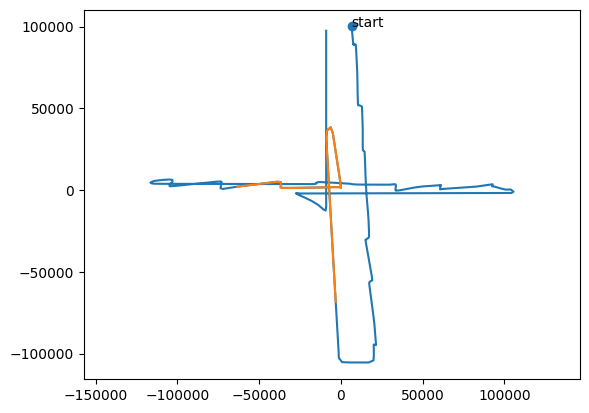

In [4]:
plt.plot(df_sadcp.Lon, df_sadcp.Lat)

t1 = pd.Timestamp('2023-10-19 6:00:00')
days1 = .4

df1 = df_sadcp[(df_sadcp.Time >= t1 - pd.Timedelta(days=days1)) & (df_sadcp.Time <= t1 + pd.Timedelta(days=days1))]
plt.plot(df1.Lon, df1.Lat)
plt.scatter(df_sadcp.Lon.iloc[0], df_sadcp.Lat.iloc[0])
plt.text(df_sadcp.Lon.iloc[0]+.1, df_sadcp.Lat.iloc[0], 'start')
plt.axis('equal')


In [5]:
u_cols = [col for col in df1.columns if 'u' in col]
v_cols = [col for col in df1.columns if 'v' in col]

df_espra = pd.DataFrame(columns=['xc', 'yc', 'w', 'Q', 'Rc', 'psi0', 'A', 'Depth'])
for (u_col, v_col) in zip(u_cols, v_cols):
    ui = df1[u_col]; vi = df1[v_col]
    xi, yi = df1.Lon, df1.Lat
    mask = ~np.isnan(xi) & ~np.isnan(yi) & ~np.isnan(ui) & ~np.isnan(vi)
    xi, yi, ui, vi = xi[mask], yi[mask], ui[mask], vi[mask]
    depth = int(u_col[2:])
    if (depth < 700) & (len(xi) > 2):
        xc, yc, w, Q, Rc, psi0, A = espra(xi, yi, ui, vi, A_flag=True)
        df_espra.loc[len(df_espra)] = {'xc': xc, 'yc': yc, 'w': w, 'Q': Q, 'Rc': Rc, 'psi0': psi0, 'A': A, 'Depth': depth}

# df_espra['sRc'], _ , _ = robust_smooth(np.arange(len(df_espra)), df_espra.Rc)
df_espra['sRc'] = smooth(df_espra.Rc, df_espra.Depth, window=300) 
df_espra['sA'], _ , _ = robust_smooth(np.arange(len(df_espra)), df_espra.A)

df_espra['sq11'], _ , _ = robust_smooth(np.arange(len(df_espra)), df_espra.Q.apply(lambda Q: Q[0,0]))
df_espra['sq12'], _ , _ = robust_smooth(np.arange(len(df_espra)), df_espra.Q.apply(lambda Q: Q[1,0]))
df_espra['sq22'], _ , _ = robust_smooth(np.arange(len(df_espra)), df_espra.Q.apply(lambda Q: Q[1,1]))

df_espra


xc           yc         w  \
0   11197.048010 -4075.515852 -0.000026   
1   12004.872319 -3321.303905 -0.000025   
2   12867.015592 -2071.439493 -0.000025   
3   12743.852449 -1072.490453 -0.000025   
4   12741.935886   162.151637 -0.000024   
..           ...          ...       ...   
62   9901.273241  1281.867717 -0.000020   
63  10997.996009  3383.655405 -0.000020   
64  12764.393953  4456.886446 -0.000019   
65  11932.894151  7359.683420 -0.000019   
66   8875.358572  6224.271993 -0.000019   

                                                    Q            Rc  \
0   [[1.0205734829454132, 0.03926168101788649], [0...  68971.497645   
1   [[1.0136572229147174, 0.020446658925388737], [...  69942.187153   
2   [[1.0180054038642012, -0.001061096330072211], ...  71311.682772   
3   [[1.032829362890477, -0.024065773848487543], [...  71615.764302   
4   [[1.033168756218125, -0.04614387425608442], [-...  71553.756836   
..                                                ...           ...   
62  [[0.9845185069156569, -0.07456081821160207], [...  57729.180136   
63  [[0.9902113674697662, -0.11848448895007549], [...  60129.367345   
64  [[0.973460482989916, -0.149027755425035], [-0....  62147.188129   
65  [[1.0234529157364136, -0.16529588619015767], [...  64184.737646   
66  [[1.0625641975495725, -0.14940775727580324], [...  65331.701858   

            psi0         A  Depth           sRc        sA      sq11      sq12  \
0   30843.583382 -0.000006     37  79076.145720 -0.000006  0.981980 -0.012213   
1   31122.076080 -0.000006     47  78192.006473 -0.000006  0.992215 -0.021379   
2   31750.872659 -0.000006     57  77448.841948 -0.000006  1.001509 -0.029663   
3   31497.563817 -0.000006     67  76812.236750 -0.000006  1.009891 -0.037096   
4   30705.584783 -0.000006     77  76253.532581 -0.000006  1.017392 -0.043711   
..           ...       ...    ...           ...       ...       ...       ...   
62  16745.802916 -0.000005    657  58456.990871 -0.000005  0.991036 -0.125603   
63  17829.624914 -0.000005    667  58519.017818 -0.000005  1.000653 -0.140750   
64  18363.638466 -0.000005    677  58611.626076 -0.000005  1.011222 -0.157004   
65  19115.316167 -0.000005    687  58800.531711 -0.000005  1.022775 -0.174398   
66  20310.611773 -0.000005    697  59159.018334 -0.000005  1.035341 -0.192964   

        sq22  
0   1.020622  
1   1.010954  
2   1.002178  
3   0.994264  
4   0.987184  
..       ...  
62  1.024463  
63  1.015956  
64  1.006566  
65  0.996265  
66  0.985025  

[67 rows x 13 columns]

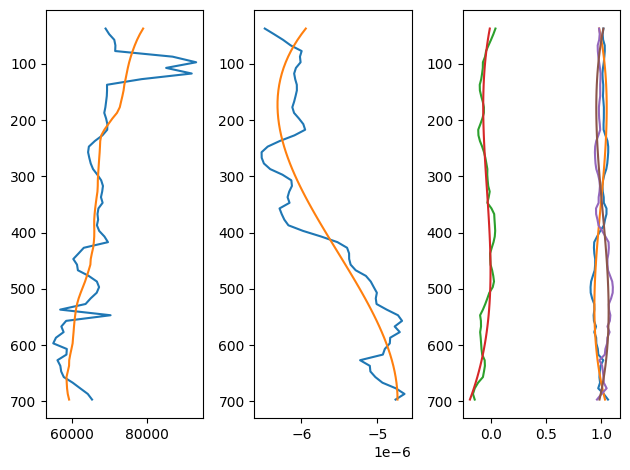

In [6]:
fig, axs = plt.subplots(1, 3)
axs[0].plot(df_espra.Rc, df_espra.Depth)
axs[0].plot(df_espra.sRc, df_espra.Depth)
axs[0].invert_yaxis()
axs[0].

axs[1].plot(df_espra.A, df_espra.Depth)
axs[1].plot(df_espra.sA, df_espra.Depth)
axs[1].invert_yaxis()

axs[2].plot(df_espra.Q.apply(lambda Q: Q[0,0]), df_espra.Depth)
axs[2].plot(df_espra.sq11, df_espra.Depth)
axs[2].plot(df_espra.Q.apply(lambda Q: Q[0,1]), df_espra.Depth)
axs[2].plot(df_espra.sq12, df_espra.Depth)
axs[2].plot(df_espra.Q.apply(lambda Q: Q[1,1]), df_espra.Depth)
axs[2].plot(df_espra.sq22, df_espra.Depth)
axs[2].invert_yaxis()

plt.tight_layout()
plt.show()


In [7]:
lon = np.linspace(df_sadcp.Lon.min(), df_sadcp.Lon.max())
lat = np.linspace(df_sadcp.Lat.min(), df_sadcp.Lat.max())
Lon, Lat = np.meshgrid(lon, lat)

U = np.zeros((Lon.shape[0], Lon.shape[1], len(df_espra)))
V = np.zeros((Lon.shape[0], Lon.shape[1], len(df_espra)))

for k in range(len(df_espra)):
    data = df_espra.iloc[k]
    
    dx, dy = Lon - data.xc, Lat - data.yc
    rho2 = data.sq11*dx**2 + 2*data.sq12*dx*dy + data.sq22*dy**2
    U[:,:,k] = (- data.sA * np.exp( - rho2 / data.sRc**2 ) * ( 2*data.sq12*dx + 2*data.sq22*dy )).T
    V[:,:,k] = (  data.sA * np.exp( - rho2 / data.sRc**2 ) * ( 2*data.sq11*dx + 2*data.sq12*dy )).T
    

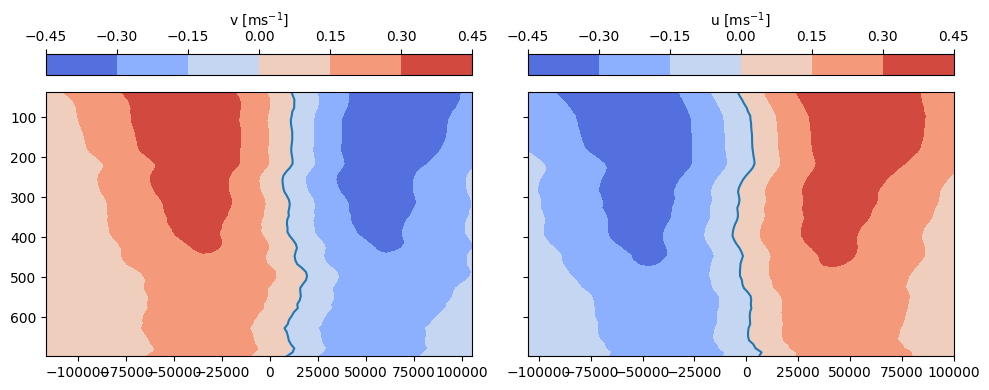

In [8]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(10, 4))

xc_surf, yc_surf = df_espra.iloc[0].xc, df_espra.iloc[0].yc
ic_surf = np.argmin(np.abs(lon - xc_surf))
jc_surf = np.argmin(np.abs(lat - yc_surf))

c1 = axs[0].contourf(lon, df_espra.Depth, V[:, jc_surf, :].T, cmap='coolwarm')
axs[0].plot(df_espra.xc, df_espra.Depth)
c2 = axs[1].contourf(lat, df_espra.Depth, U[ic_surf, :, :].T , cmap='coolwarm')
axs[1].plot(df_espra.yc, df_espra.Depth)
axs[0].invert_yaxis()

fig.colorbar(c1, ax=axs[0], orientation='horizontal', location='top', label=r'v [ms$^{-1}$]')
fig.colorbar(c2, ax=axs[1], orientation='horizontal', location='top', label=r'u [ms$^{-1}$]')

plt.tight_layout()
plt.show()


In [9]:
df_espra

xc           yc         w  \
0   11197.048010 -4075.515852 -0.000026   
1   12004.872319 -3321.303905 -0.000025   
2   12867.015592 -2071.439493 -0.000025   
3   12743.852449 -1072.490453 -0.000025   
4   12741.935886   162.151637 -0.000024   
..           ...          ...       ...   
62   9901.273241  1281.867717 -0.000020   
63  10997.996009  3383.655405 -0.000020   
64  12764.393953  4456.886446 -0.000019   
65  11932.894151  7359.683420 -0.000019   
66   8875.358572  6224.271993 -0.000019   

                                                    Q            Rc  \
0   [[1.0205734829454132, 0.03926168101788649], [0...  68971.497645   
1   [[1.0136572229147174, 0.020446658925388737], [...  69942.187153   
2   [[1.0180054038642012, -0.001061096330072211], ...  71311.682772   
3   [[1.032829362890477, -0.024065773848487543], [...  71615.764302   
4   [[1.033168756218125, -0.04614387425608442], [-...  71553.756836   
..                                                ...           ...   
62  [[0.9845185069156569, -0.07456081821160207], [...  57729.180136   
63  [[0.9902113674697662, -0.11848448895007549], [...  60129.367345   
64  [[0.973460482989916, -0.149027755425035], [-0....  62147.188129   
65  [[1.0234529157364136, -0.16529588619015767], [...  64184.737646   
66  [[1.0625641975495725, -0.14940775727580324], [...  65331.701858   

            psi0         A  Depth           sRc        sA      sq11      sq12  \
0   30843.583382 -0.000006     37  79076.145720 -0.000006  0.981980 -0.012213   
1   31122.076080 -0.000006     47  78192.006473 -0.000006  0.992215 -0.021379   
2   31750.872659 -0.000006     57  77448.841948 -0.000006  1.001509 -0.029663   
3   31497.563817 -0.000006     67  76812.236750 -0.000006  1.009891 -0.037096   
4   30705.584783 -0.000006     77  76253.532581 -0.000006  1.017392 -0.043711   
..           ...       ...    ...           ...       ...       ...       ...   
62  16745.802916 -0.000005    657  58456.990871 -0.000005  0.991036 -0.125603   
63  17829.624914 -0.000005    667  58519.017818 -0.000005  1.000653 -0.140750   
64  18363.638466 -0.000005    677  58611.626076 -0.000005  1.011222 -0.157004   
65  19115.316167 -0.000005    687  58800.531711 -0.000005  1.022775 -0.174398   
66  20310.611773 -0.000005    697  59159.018334 -0.000005  1.035341 -0.192964   

        sq22  
0   1.020622  
1   1.010954  
2   1.002178  
3   0.994264  
4   0.987184  
..       ...  
62  1.024463  
63  1.015956  
64  1.006566  
65  0.996265  
66  0.985025  

[67 rows x 13 columns]

11688.064097255596 2593.53341424351


(np.float64(-127677.08694791736),
 np.float64(116708.22479377297),
 np.float64(-115762.28835995645),
 np.float64(110372.67747337639))

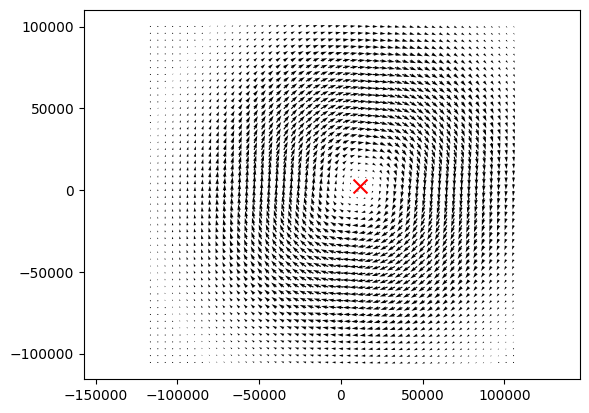

In [10]:
k = 10

data = df_espra.iloc[k]
plt.quiver(Lon, Lat, U[:,:,k].T, V[:,:,k].T)
plt.scatter(data.xc, data.yc, marker='x', s=100, color='r')
print(data.xc, data.yc)
plt.axis('equal')


In [11]:
TD, *_ = tilt_distance_LI(df_espra.xc, df_espra.yc, df_espra.Depth)
TD


np.float64(18987.577791865333)

### Generalise

#### Find best day interval

In [12]:
# xc_approx, yc_approx = 154.41029505600693, -37.94723154293799
xc_approx, yc_approx = 0.0, 0.0

df_best_day_int = pd.DataFrame(columns=['day_int', 'n'])
for days in np.arange(.1, 1.6, .1):
        
    start = (df_sadcp.Time.min() + pd.Timedelta(days=days)).round('h')
    end   = (df_sadcp.Time.max() - pd.Timedelta(days=days)).round('h')
    times = pd.date_range(start, end, freq='1h')
    
    dic_tframe = {}
    n = 0
    for t in times:
        
        df_tframe = df_sadcp[(df_sadcp.Time >= t - pd.Timedelta(days=days)) & (df_sadcp.Time <= t + pd.Timedelta(days=days))]
        
        u_cols = ['u_37']
        v_cols = ['v_37']
        
        df_espra_tframe = pd.DataFrame(columns=['xc', 'yc', 'w', 'Q', 'Rc', 'psi0', 'A', 'Depth'])
        for (u_col, v_col) in zip(u_cols, v_cols):
            ui = df_tframe[u_col]; vi = df_tframe[v_col]
            xi, yi = df_tframe.Lon, df_tframe.Lat
            mask = ~np.isnan(xi) & ~np.isnan(yi) & ~np.isnan(ui) & ~np.isnan(vi)
            xi, yi, ui, vi = xi[mask], yi[mask], ui[mask], vi[mask]
            depth = int(u_col[2:])
            if (depth < 700) & (len(xi) > 2):
                xc, yc, w, Q, Rc, psi0, A = espra(xi, yi, ui, vi, A_flag=True)
                # if np.hypot(xc - xc_approx, yc - yc_approx) < .3:
                if np.hypot(xc - xc_approx, yc - yc_approx) < 50000:
                    df_espra_tframe.loc[len(df_espra_tframe)] = {'xc': xc, 'yc': yc, 'w': w,
                                                             'Q': Q, 'Rc': Rc, 'psi0': psi0, 'A': A,
                                                                 'Depth': depth}

        # if df_espra_tframe.Rc.notna().all():
        # if len(df_espra_tframe):
        if (len(df_espra_tframe) >= len(u_cols)*.7) & (df_espra_tframe.Rc.notna().all()):
            dic_tframe[t] = df_espra_tframe
            n += 1
    df_best_day_int.loc[len(df_best_day_int)] = {'day_int': days, 'n': n}
df_best_day_int


/home/z5297792/UNSW-MRes/MRes/modules/utils.py:407: RuntimeWarning: overflow encountered in exp
  exp_term = np.exp(-rho2 / Rc**2)
/home/z5297792/UNSW-MRes/MRes/modules/utils.py:410: RuntimeWarning: overflow encountered in square
  return np.sum((ui - u_model)**2 + (vi - v_model)**2)
/home/z5297792/.local/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/z5297792/UNSW-MRes/MRes/modules/utils.py:407: RuntimeWarning: overflow encountered in exp
  exp_term = np.exp(-rho2 / Rc**2)
/home/z5297792/.local/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/z5297792/UNSW-MRes/MRes/modules/utils.py:410: RuntimeWarning: overflow encountered in square
  return np.sum((ui - u_model)**2 + (vi - v_model)**2)
/home/z5297792/.local/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encou

day_int   n
0       0.1  37
1       0.2  40
2       0.3  51
3       0.4  59
4       0.5  67
5       0.6  77
6       0.7  76
7       0.8  70
8       0.9  66
9       1.0  61
10      1.1  56
11      1.2  52
12      1.3  46
13      1.4  42
14      1.5  37

In [13]:
# xc_approx, yc_approx = 154.41029505600693, -37.94723154293799
xc_approx, yc_approx = 0.0, 0.0

days = .3
        
start = (df_sadcp.Time.min() + pd.Timedelta(days=days)).round('h')
end   = (df_sadcp.Time.max() - pd.Timedelta(days=days)).round('h')
times = pd.date_range(start, end, freq='1h')

dic_tframe = {}
n = 0
u_cols = [col for col in df_sadcp.columns if 'u' in col]
v_cols = [col for col in df_sadcp.columns if 'v' in col]
for t in times:
    
    df_tframe = df_sadcp[(df_sadcp.Time >= t - pd.Timedelta(days=days)) & (df_sadcp.Time <= t + pd.Timedelta(days=days))]
    
    df_espra_tframe = pd.DataFrame(columns=['xc', 'yc', 'w', 'Q', 'Rc', 'psi0', 'A', 'Depth'])
    for (u_col, v_col) in zip(u_cols, v_cols):
        ui = df_tframe[u_col]; vi = df_tframe[v_col]
        xi, yi = df_tframe.Lon, df_tframe.Lat
        mask = ~np.isnan(xi) & ~np.isnan(yi) & ~np.isnan(ui) & ~np.isnan(vi)
        xi, yi, ui, vi = xi[mask], yi[mask], ui[mask], vi[mask]
        depth = int(u_col[2:])
        if (depth < 700) & (len(xi) > 2):
            xc, yc, w, Q, Rc, psi0, A = espra(xi, yi, ui, vi, plot_flag=False, A_flag=True) # plots are lots
            # if np.hypot(xc - xc_approx, yc - yc_approx) < .3:
            if np.hypot(xc - xc_approx, yc - yc_approx) < 50000:
                df_espra_tframe.loc[len(df_espra_tframe)] = {'xc': xc, 'yc': yc, 'w': w,
                                                         'Q': Q, 'Rc': Rc, 'psi0': psi0, 'A': A, 'Depth': depth}
    # if df_espra_tframe.Rc.notna().all():       
    # if len(df_espra_tframe) >= len(u_cols)*.7:
    # if len(df_espra_tframe) == len(u_cols):
    if (len(df_espra_tframe) >= len(u_cols)*.7) & (df_espra_tframe.Rc.notna().all()):
        dic_tframe[t] = df_espra_tframe
        n += 1
print(f'{n} successful profiles using {days} day intervals')


/home/z5297792/UNSW-MRes/MRes/modules/utils.py:410: RuntimeWarning: overflow encountered in square
  return np.sum((ui - u_model)**2 + (vi - v_model)**2)
/home/z5297792/.local/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/z5297792/UNSW-MRes/MRes/modules/utils.py:410: RuntimeWarning: overflow encountered in square
  return np.sum((ui - u_model)**2 + (vi - v_model)**2)
/home/z5297792/.local/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/z5297792/UNSW-MRes/MRes/modules/utils.py:410: RuntimeWarning: overflow encountered in square
  return np.sum((ui - u_model)**2 + (vi - v_model)**2)
/home/z5297792/.local/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/z5297792/UNSW-MRes/MRes/modules/utils.py:410: RuntimeWarning: ov

36 successful profiles using 0.3 day intervals


2356


(-105483.42627662314, 100093.81539004308)

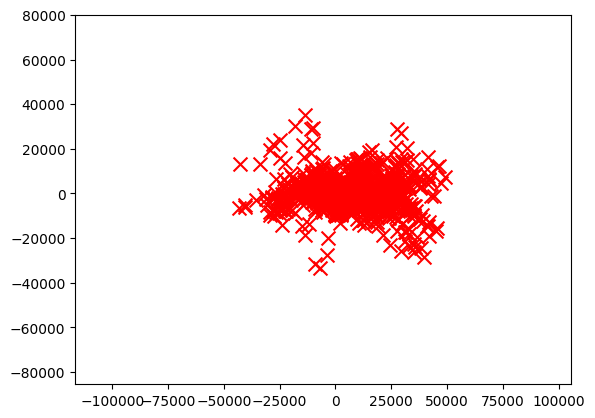

In [14]:
n = 0
for df in dic_tframe.values():
    for k in range(len(df)):
        data = df.iloc[k]
        plt.scatter(data.xc, data.yc, marker='x', s=100, color='r')
        n += 1
print(n)
plt.axis('equal')
plt.xlim(Lon.min(), Lon.max())
plt.ylim(Lat.min(), Lat.max())


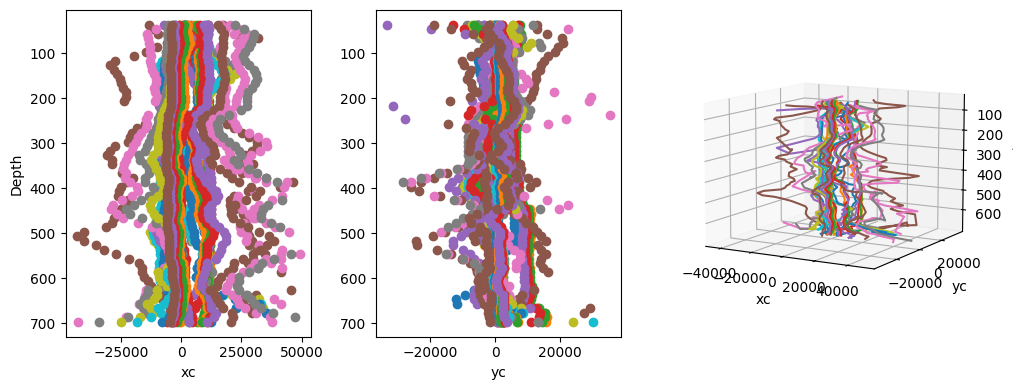

In [15]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 4))
gs = fig.add_gridspec(1, 3, width_ratios=[1, 1, 1.2])
axs = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1])]
ax3d = fig.add_subplot(gs[0, 2], projection='3d')

for t, df in dic_tframe.items():
    axs[0].scatter(df.xc, df.Depth, label=t)
    axs[1].scatter(df.yc, df.Depth)
    ax3d.plot(df.xc, df.yc, df.Depth, label=t)

axs[0].invert_yaxis()
axs[1].invert_yaxis()
ax3d.invert_zaxis()

axs[0].set_xlabel('xc')
axs[1].set_xlabel('yc')
axs[0].set_ylabel('Depth')
ax3d.set_xlabel('xc')
ax3d.set_ylabel('yc')
ax3d.set_zlabel('Depth')
ax3d.view_init(elev=10, azim=-60)

plt.tight_layout()
plt.show()


(np.float64(-127677.08694791736),
 np.float64(116708.22479377297),
 np.float64(-115762.28835995645),
 np.float64(110372.67747337639))

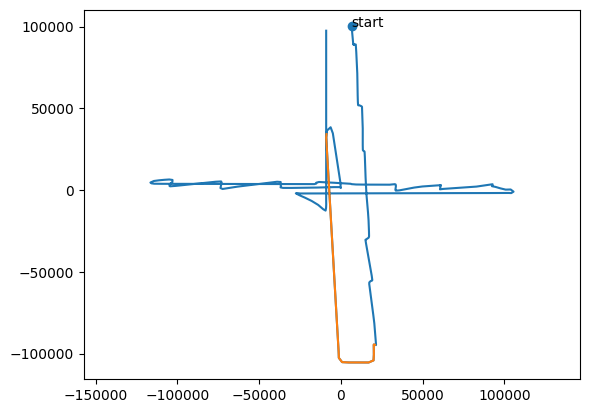

In [16]:
plt.plot(df_sadcp.Lon, df_sadcp.Lat)

t = list(dic_tframe.keys())[5]

df = df_sadcp[(df_sadcp.Time >= t - pd.Timedelta(days=days)) & (df_sadcp.Time <= t + pd.Timedelta(days=days))]
plt.plot(df.Lon, df.Lat)
plt.scatter(df_sadcp.Lon.iloc[0], df_sadcp.Lat.iloc[0])
plt.text(df_sadcp.Lon.iloc[0]+.1, df_sadcp.Lat.iloc[0], 'start')
plt.axis('equal')


In [22]:
def vel_plotter(t_idx):
    t = list(dic_tframe.keys())[t_idx]
    df = dic_tframe[t].copy()

    # df['sRc'], _, _ = robust_smooth(np.arange(len(df)), df.Rc)
    df['sRc'] = smooth(df.Rc, df.Depth, window=500) 
    df['sA'], _, _ = robust_smooth(np.arange(len(df)), df.A)
    
    df['sq11'], _, _ = robust_smooth(np.arange(len(df)), df.Q.apply(lambda Q: Q[0,0]))
    df['sq12'], _, _ = robust_smooth(np.arange(len(df)), df.Q.apply(lambda Q: Q[1,0]))
    df['sq22'], _, _ = robust_smooth(np.arange(len(df)), df.Q.apply(lambda Q: Q[1,1]))
    
    U = np.zeros((Lon.shape[0], Lon.shape[1], len(df)))
    V = np.zeros((Lon.shape[0], Lon.shape[1], len(df)))

    fig, axs = plt.subplots(1, 3, figsize=(15, 4))
    
    for k in range(len(df)):
        data = df.iloc[k]
        
        dx, dy = Lon - data.xc, Lat - data.yc
        rho2 = data.sq11*dx**2 + 2*data.sq12*dx*dy + data.sq22*dy**2
        U[:,:,k] = (- data.sA * np.exp( - rho2 / data.sRc**2 ) * ( 2*data.sq12*dx + 2*data.sq22*dy )).T
        V[:,:,k] = (  data.sA * np.exp( - rho2 / data.sRc**2 ) * ( 2*data.sq11*dx + 2*data.sq12*dy )).T

        axs[2].contour(Lon, Lat, rho2, levels=[data.sRc**2/2], colors='r')
    
    xc_surf, yc_surf = df.iloc[0].xc, df.iloc[0].yc
    ic_surf = np.argmin(np.abs(lon - xc_surf))
    jc_surf = np.argmin(np.abs(lat - yc_surf))
    
    c1 = axs[0].contourf(lon, df.Depth, V[:, jc_surf, :].T, cmap='coolwarm')
    axs[0].plot(df.xc, df.Depth, color='k')
    axs[0].set_xlabel('Lon'); axs[0].set_ylabel('Depth (m)')
    axs[0].invert_yaxis()
    c2 = axs[1].contourf(lat, df.Depth, U[ic_surf, :, :].T, cmap='coolwarm')
    axs[1].plot(df.yc, df.Depth, color='k')
    axs[1].set_xlabel('Lat'); axs[0].set_ylabel('Depth (m)')
    axs[1].invert_yaxis()
    fig.colorbar(c1, ax=axs[0], orientation='horizontal', location='top', label=r'v [ms$^{-1}$]')
    fig.colorbar(c2, ax=axs[1], orientation='horizontal', location='top', label=r'u [ms$^{-1}$]')

    axs[2].plot(df_sadcp.Lon, df_sadcp.Lat)
    df_sec = df_sadcp[(df_sadcp.Time >= t - pd.Timedelta(days=days)) & (df_sadcp.Time <= t + pd.Timedelta(days=days))]
    axs[2].plot(df_sec.Lon, df_sec.Lat)
    axs[2].scatter(df_sadcp.Lon.iloc[0], df_sadcp.Lat.iloc[0])
    axs[2].text(df_sadcp.Lon.iloc[0]+.1, df_sadcp.Lat.iloc[0], 'start')
    axs[2].scatter(df.xc, df.yc, marker='.', color='r')
    axs[2].axis('equal')

    fig.suptitle(f't idx {t_idx}, {t}', fontsize=16)
    plt.tight_layout()
    plt.show()


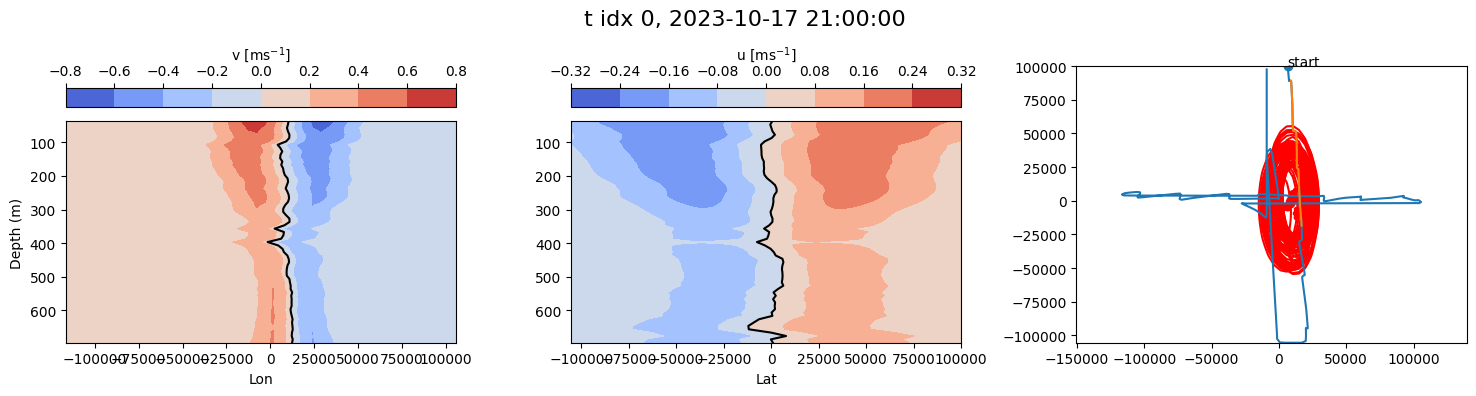

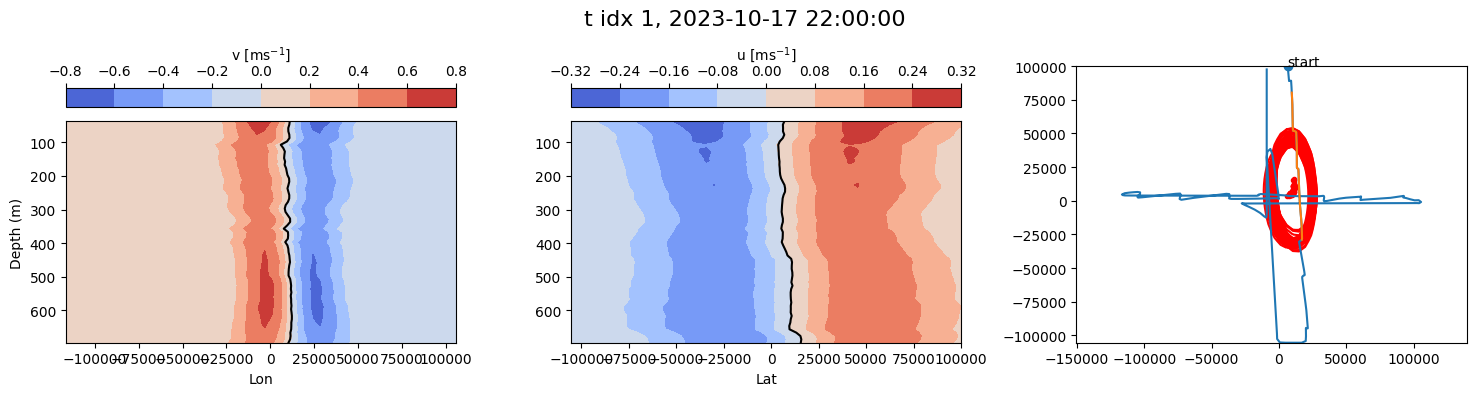

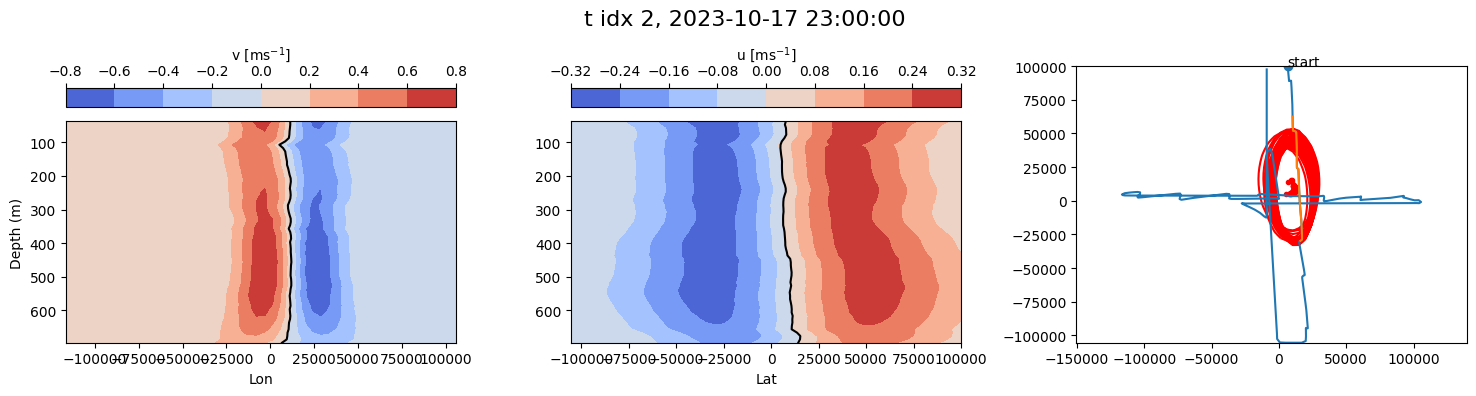

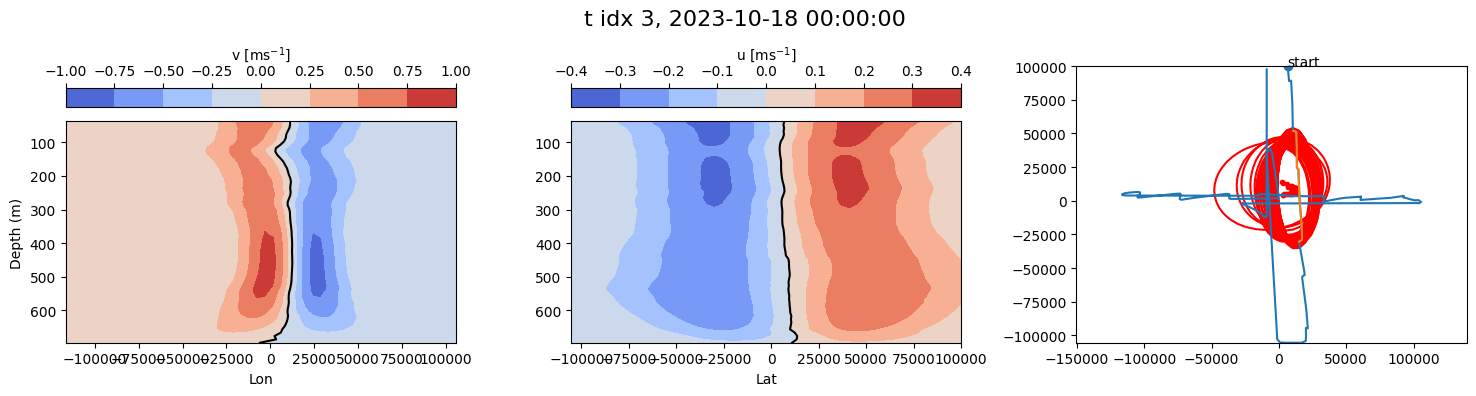

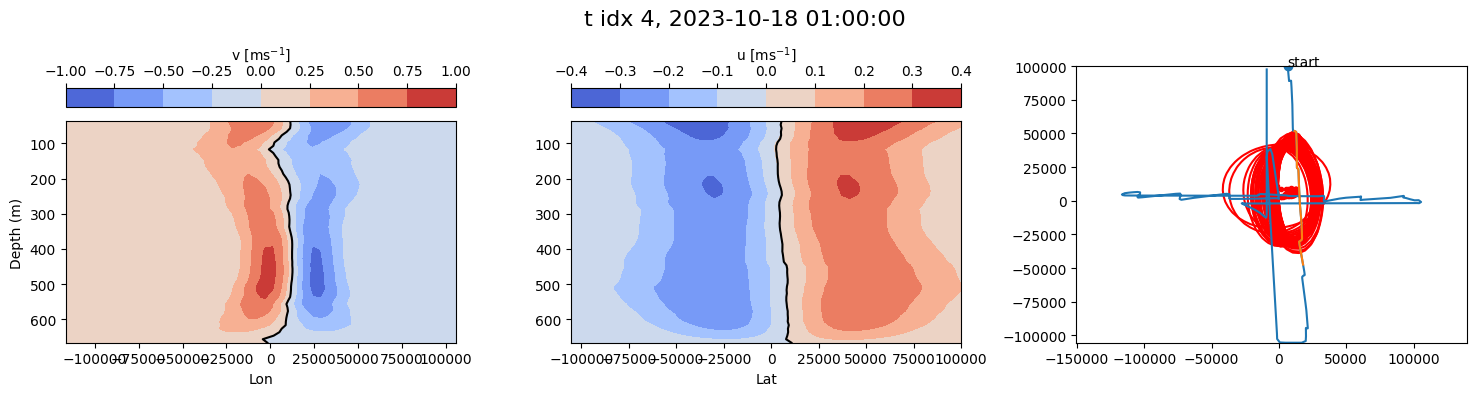

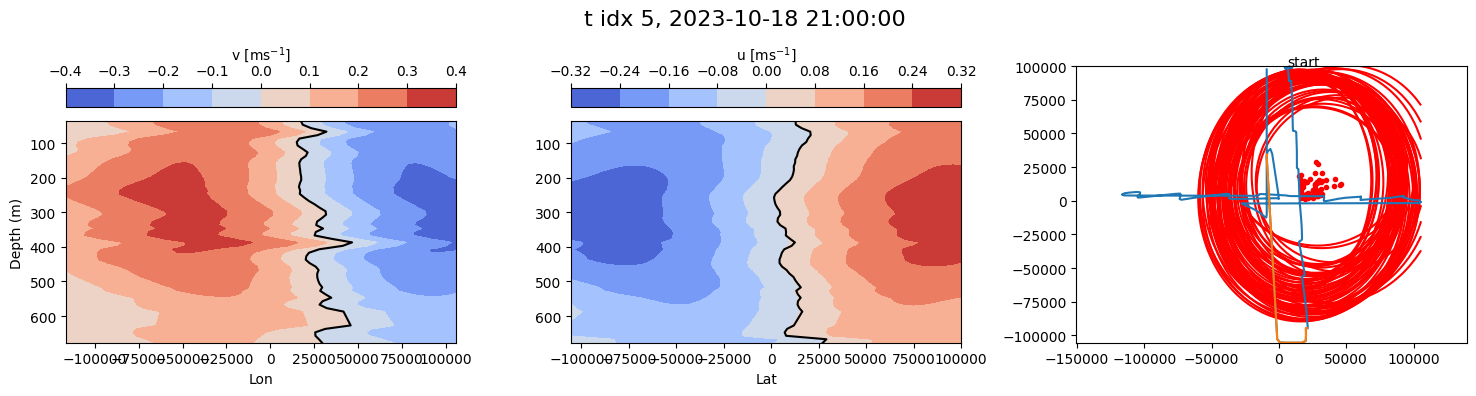

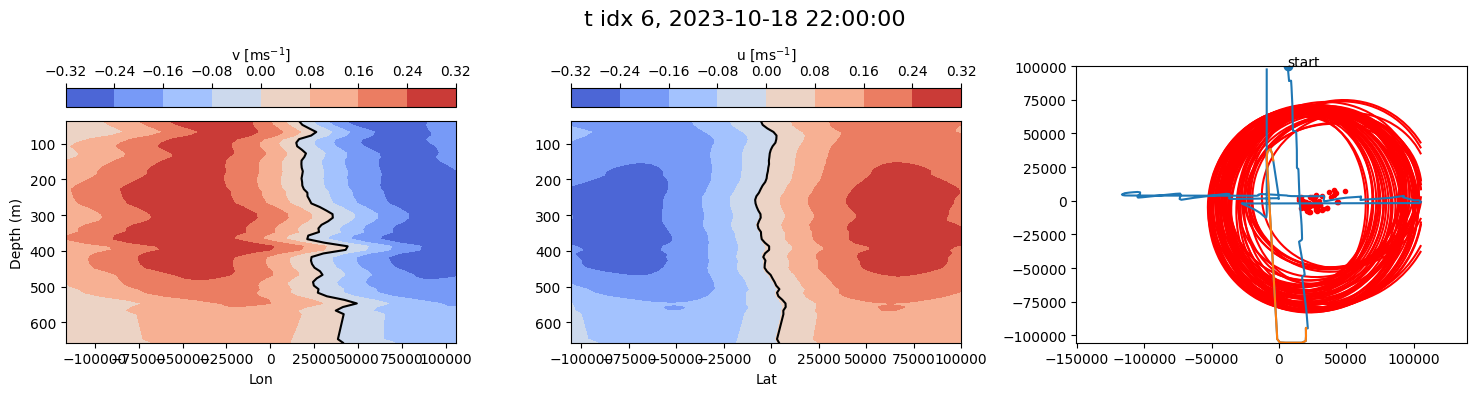

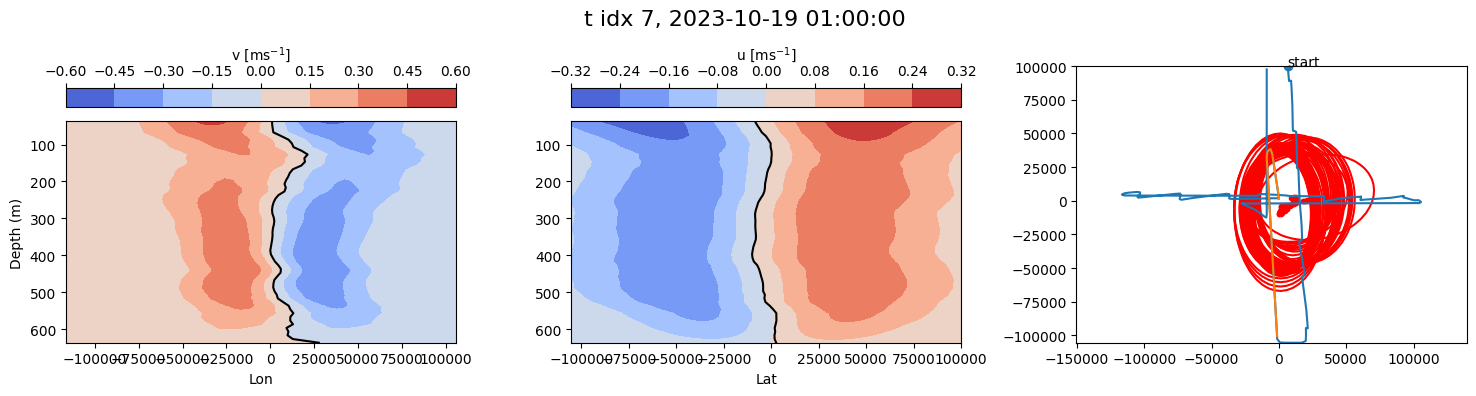

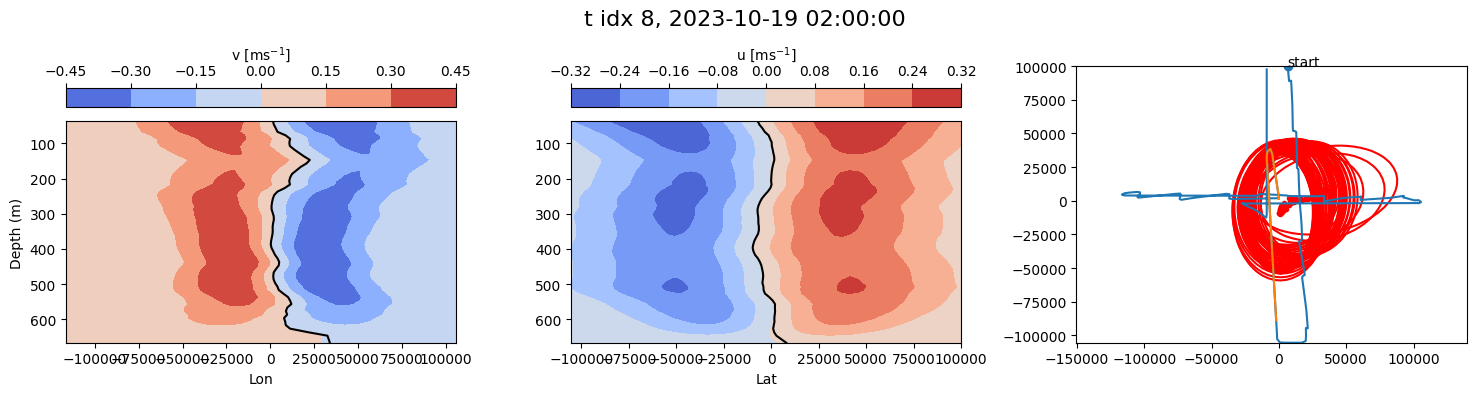

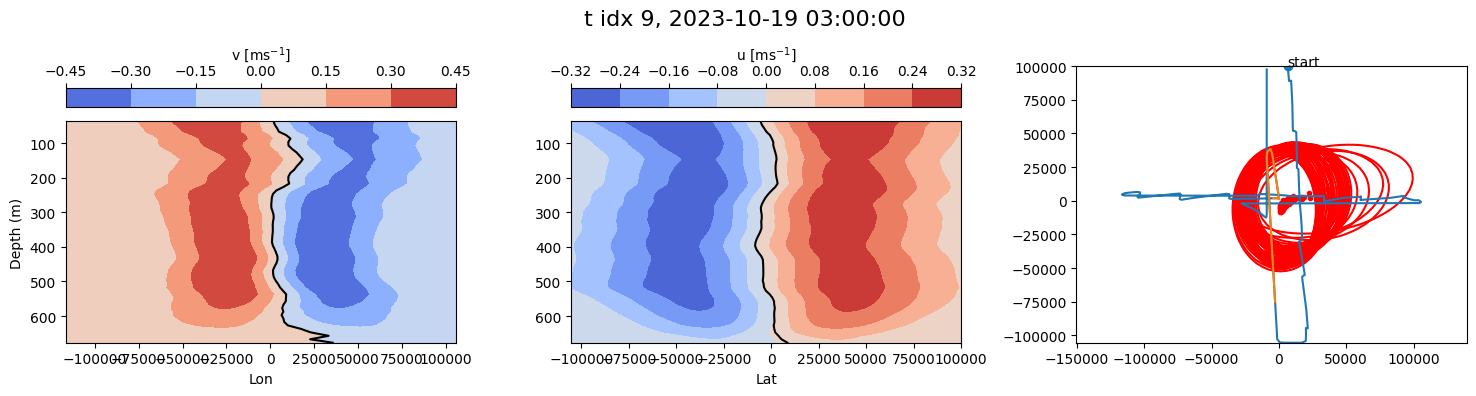

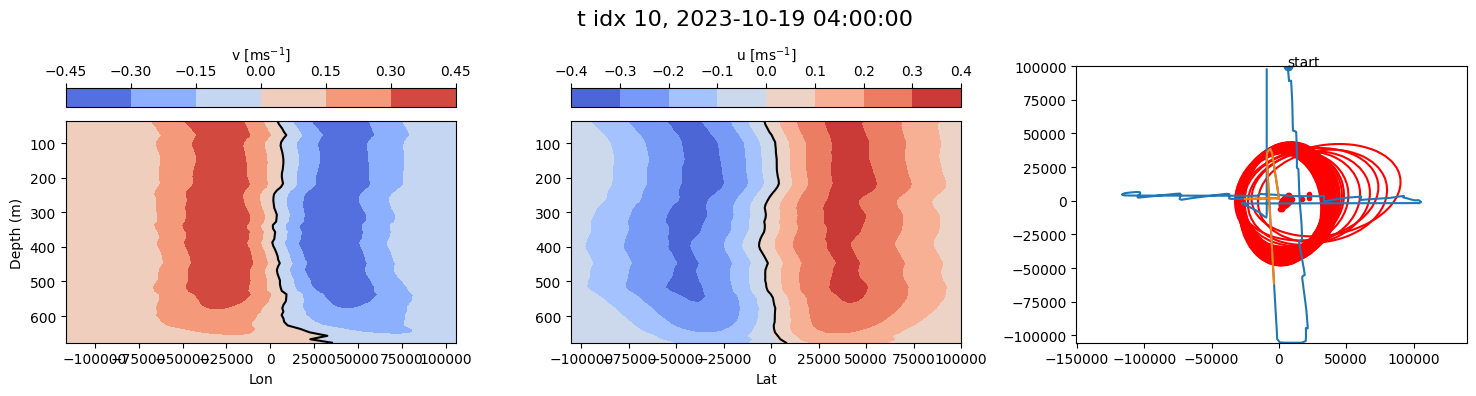

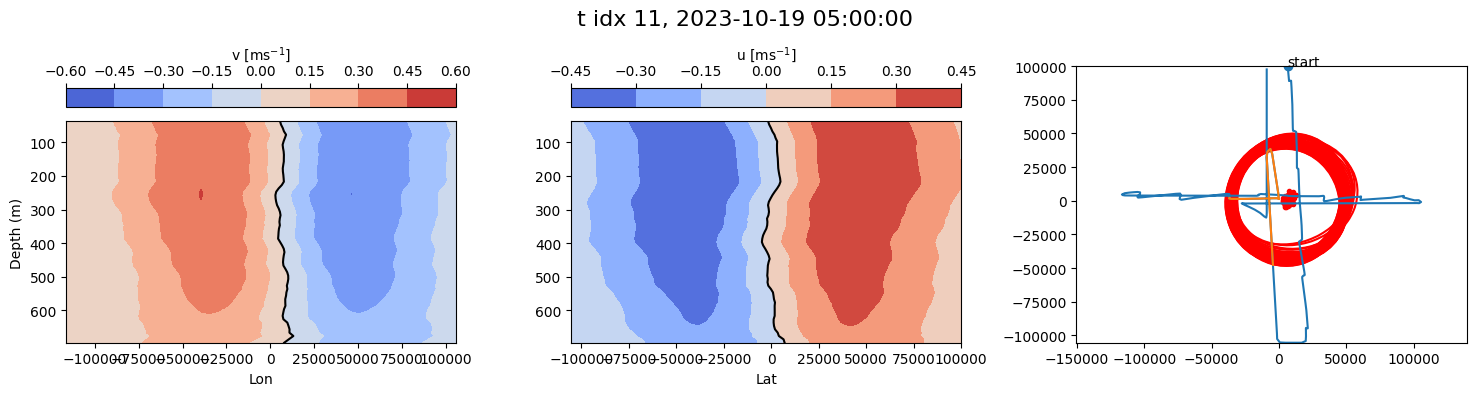

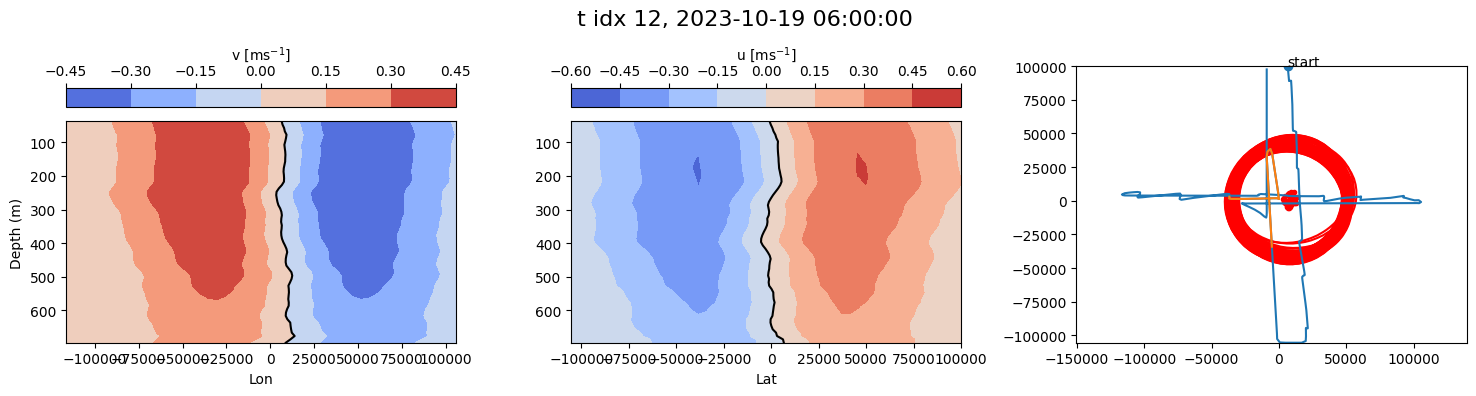

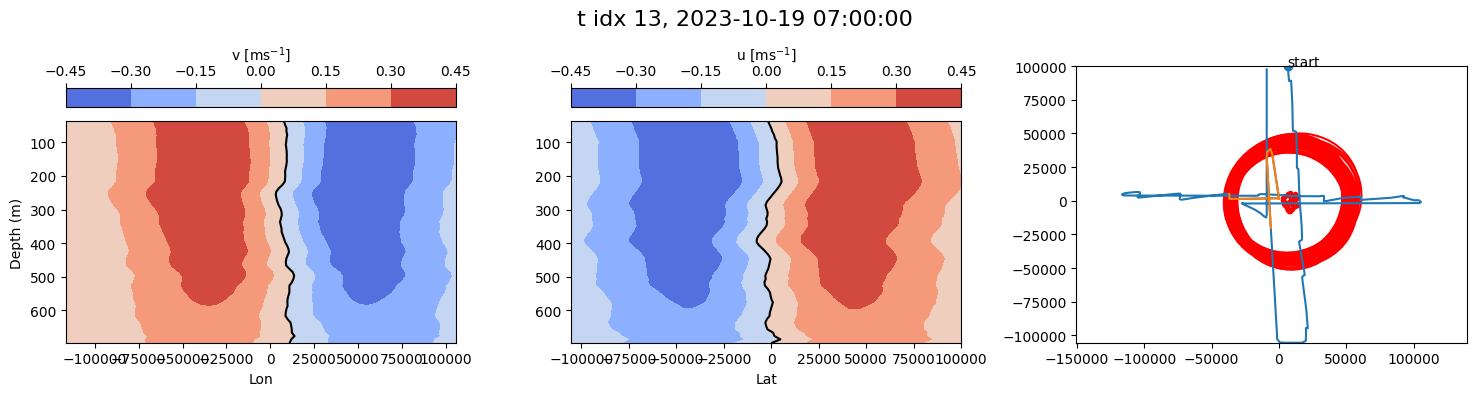

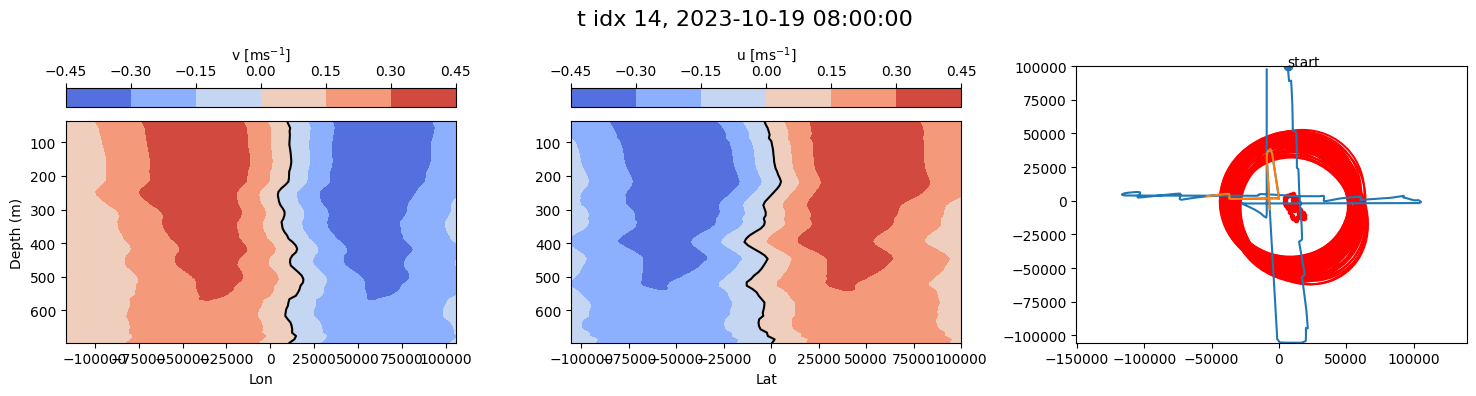

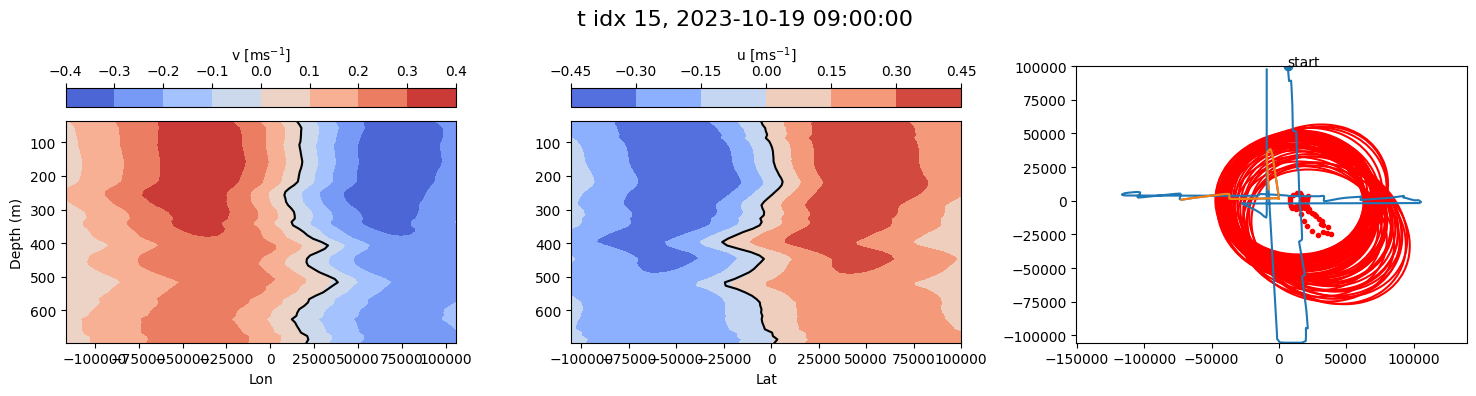

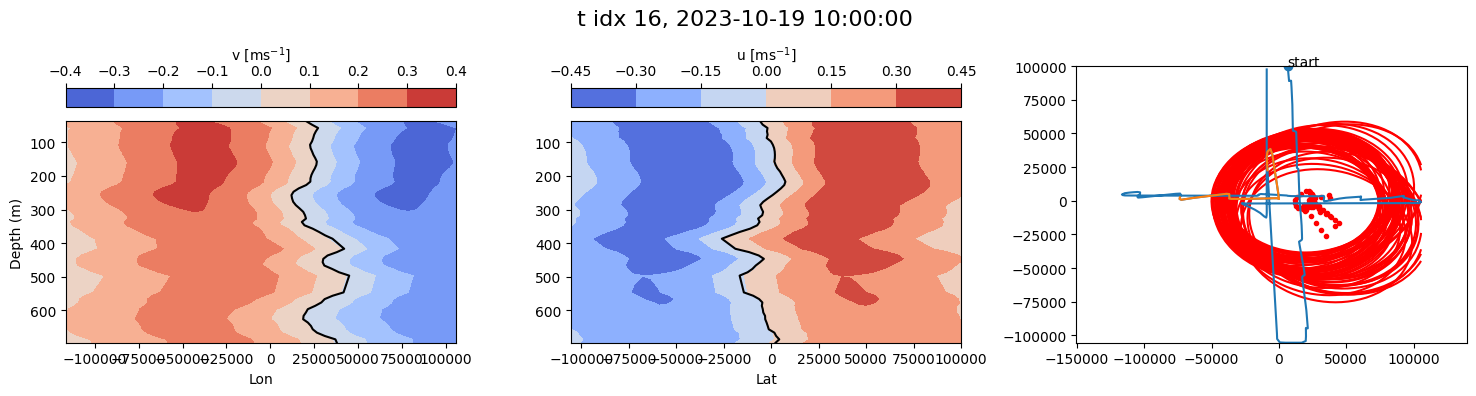

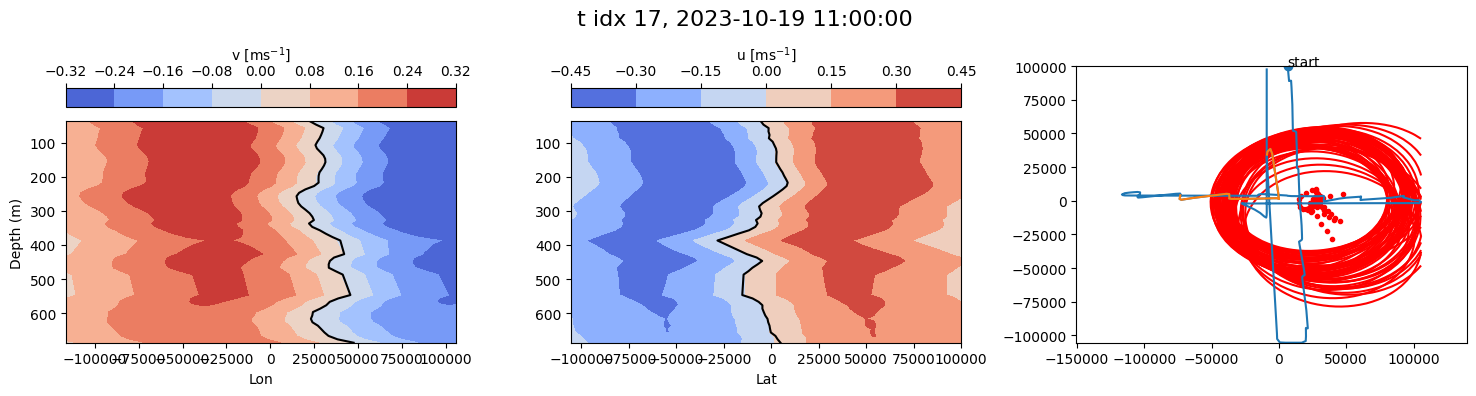

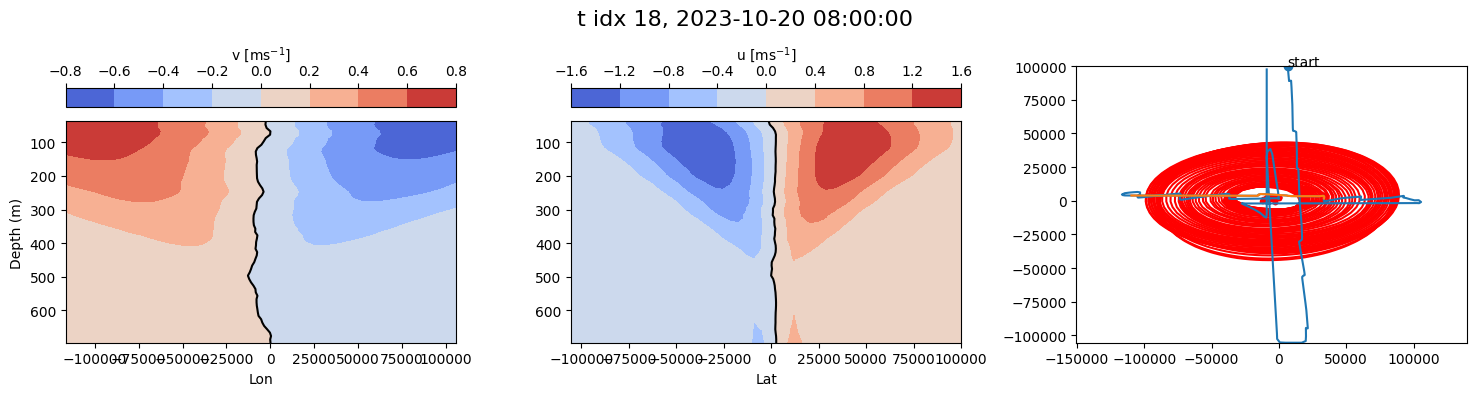

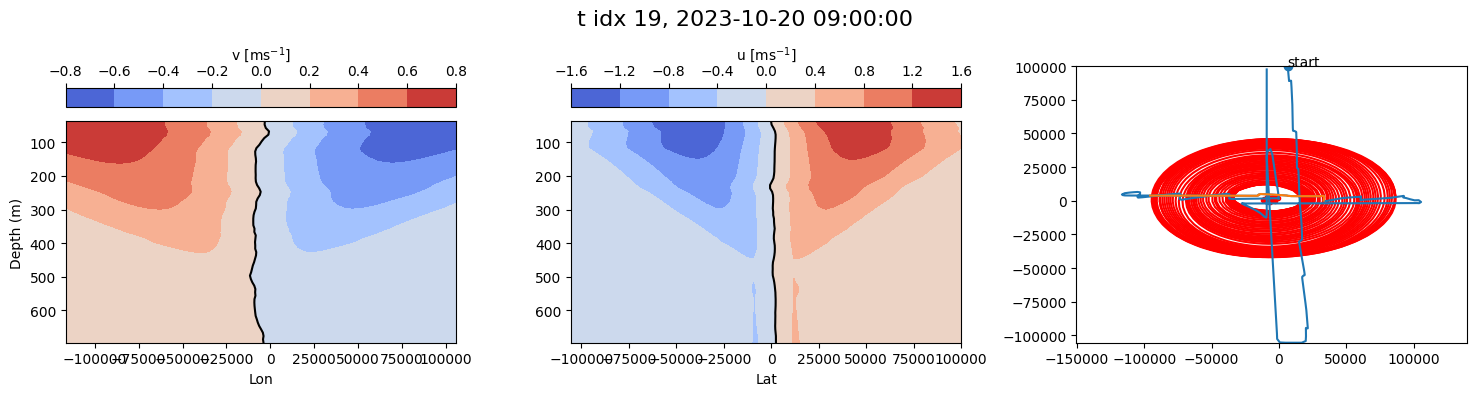

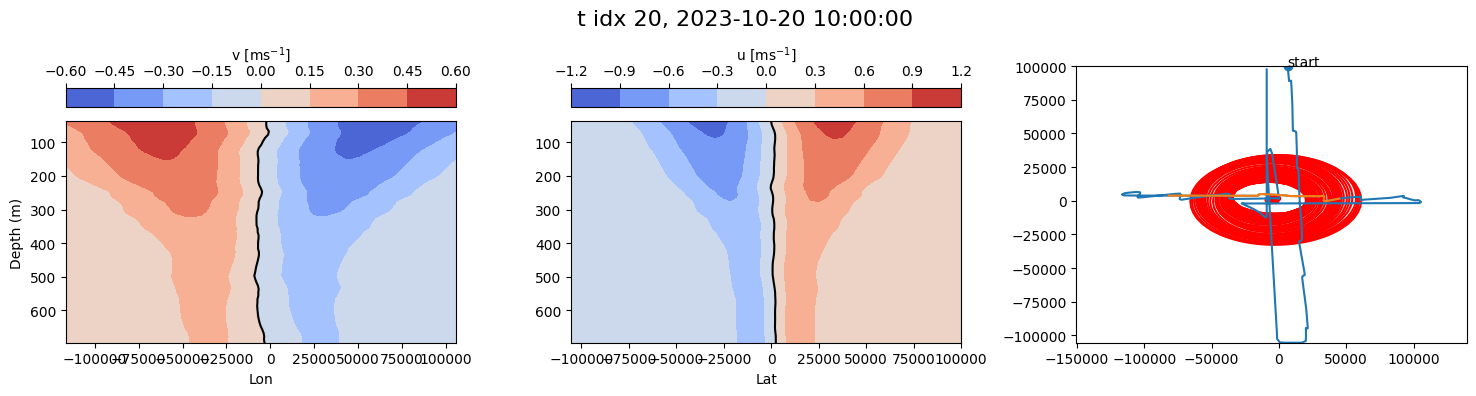

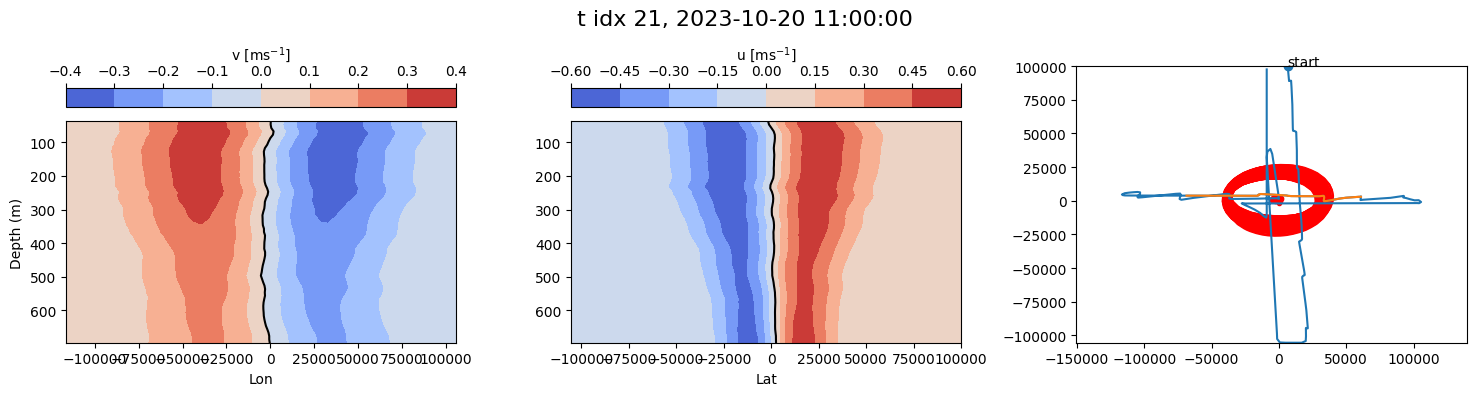

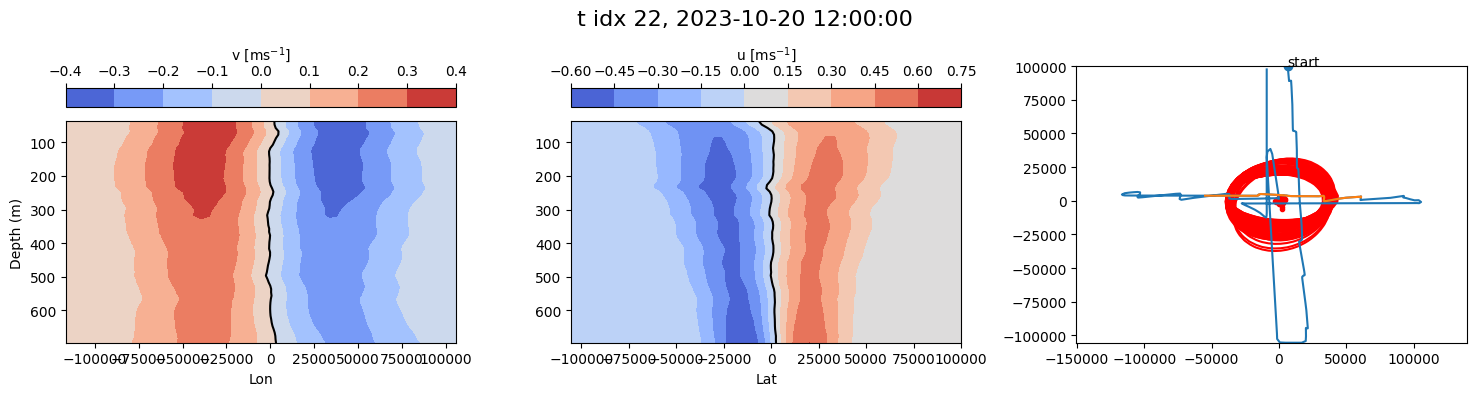

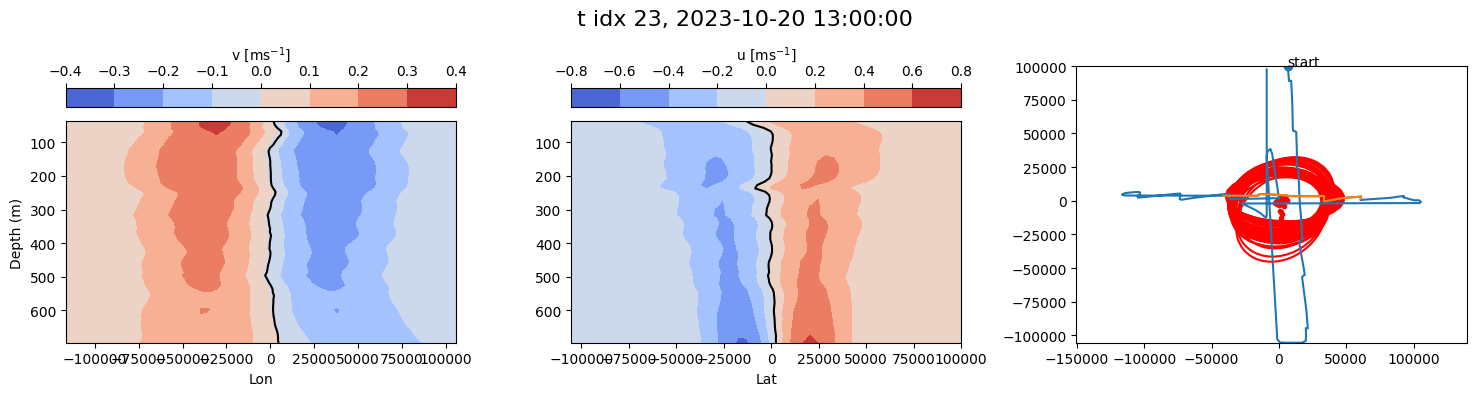

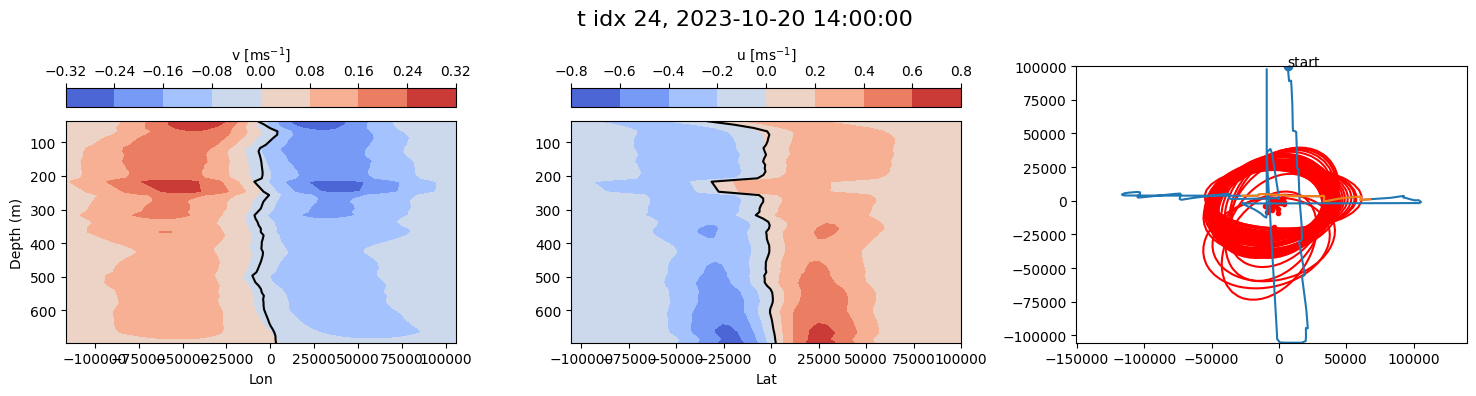

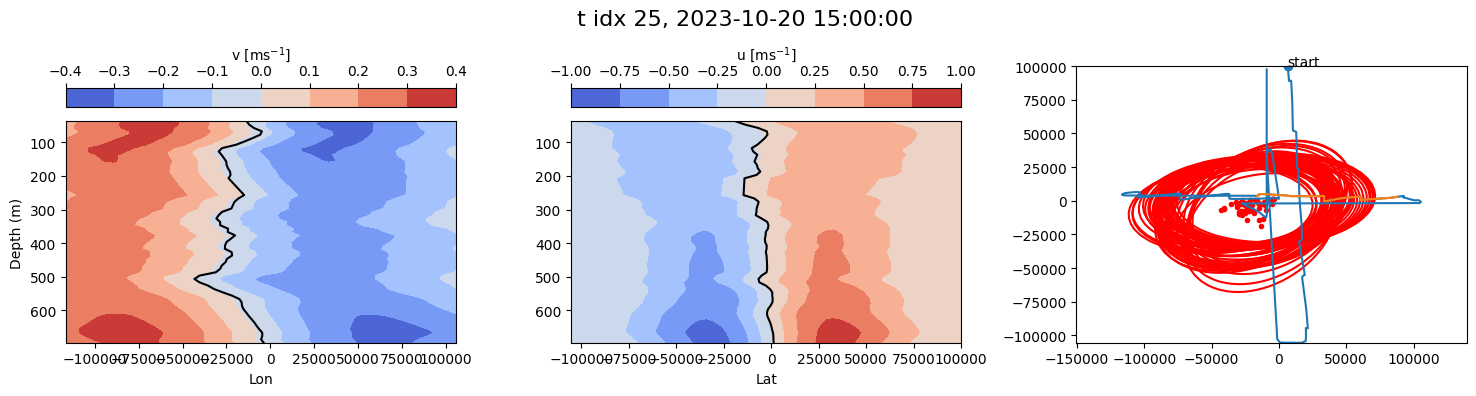

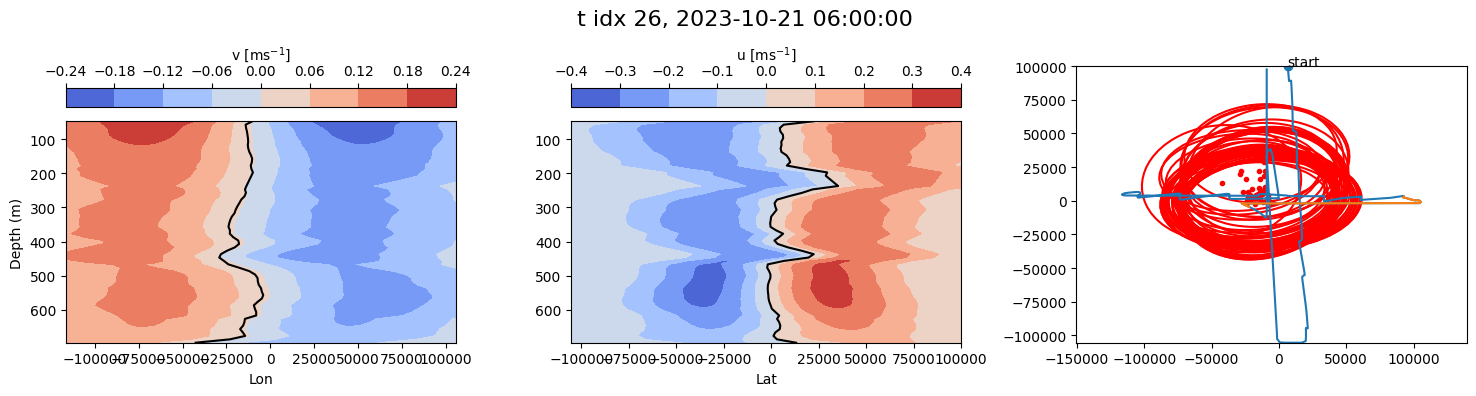

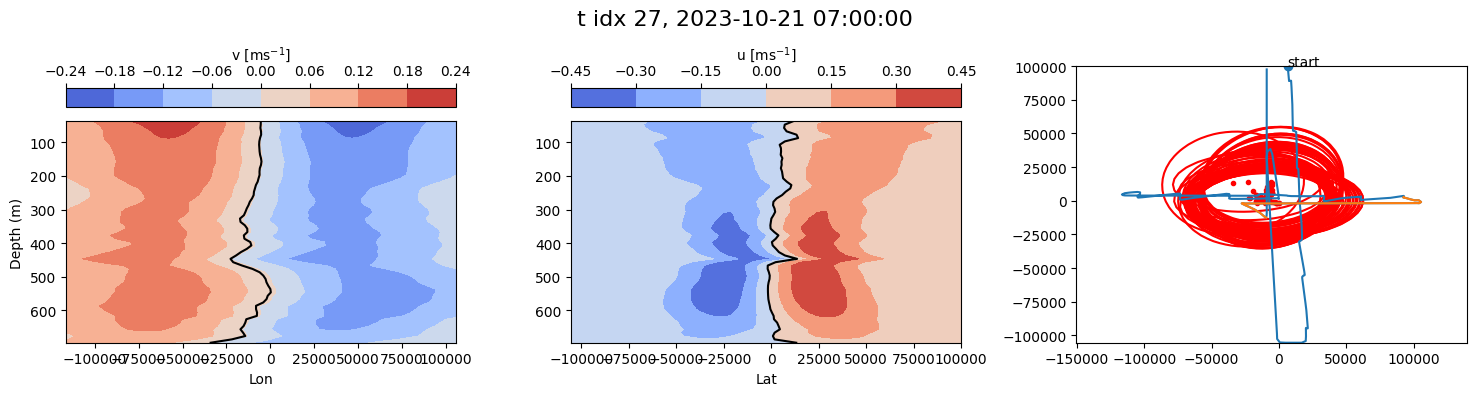

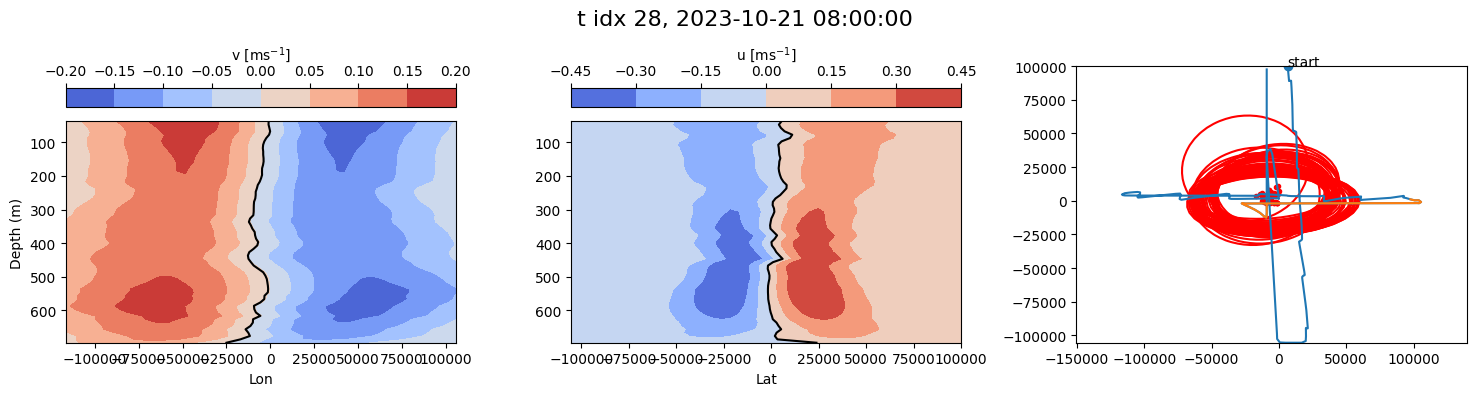

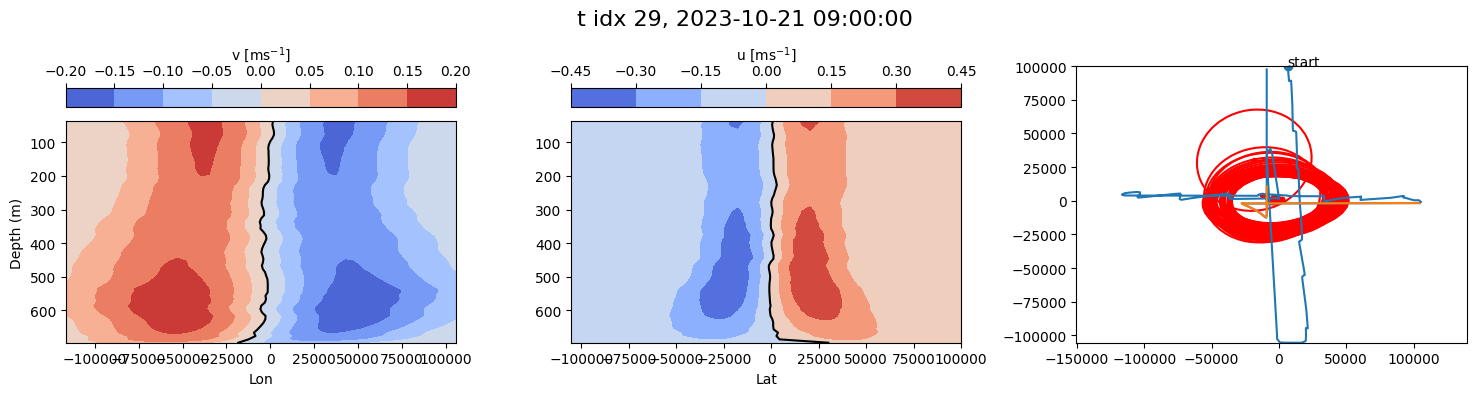

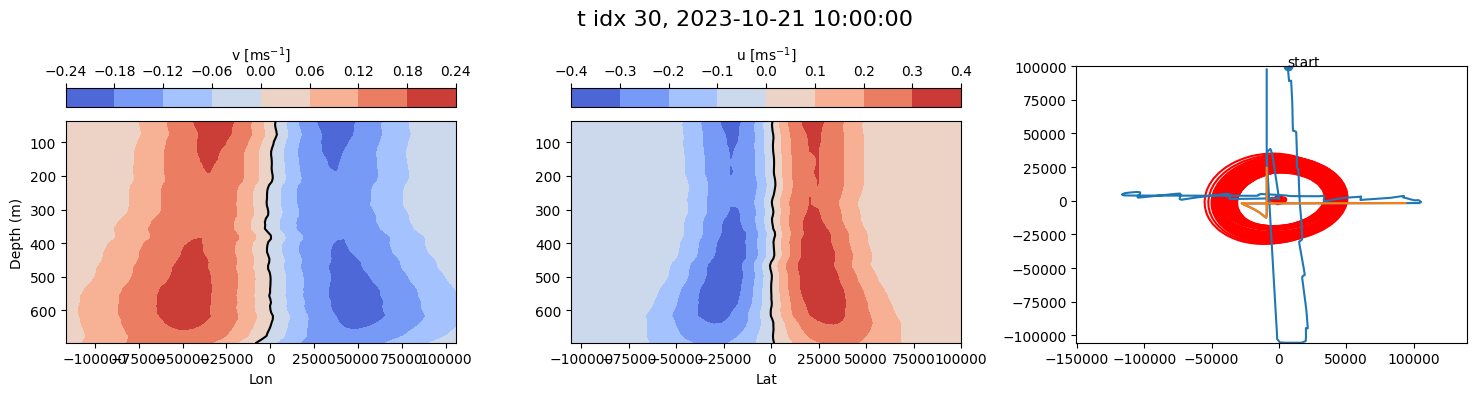

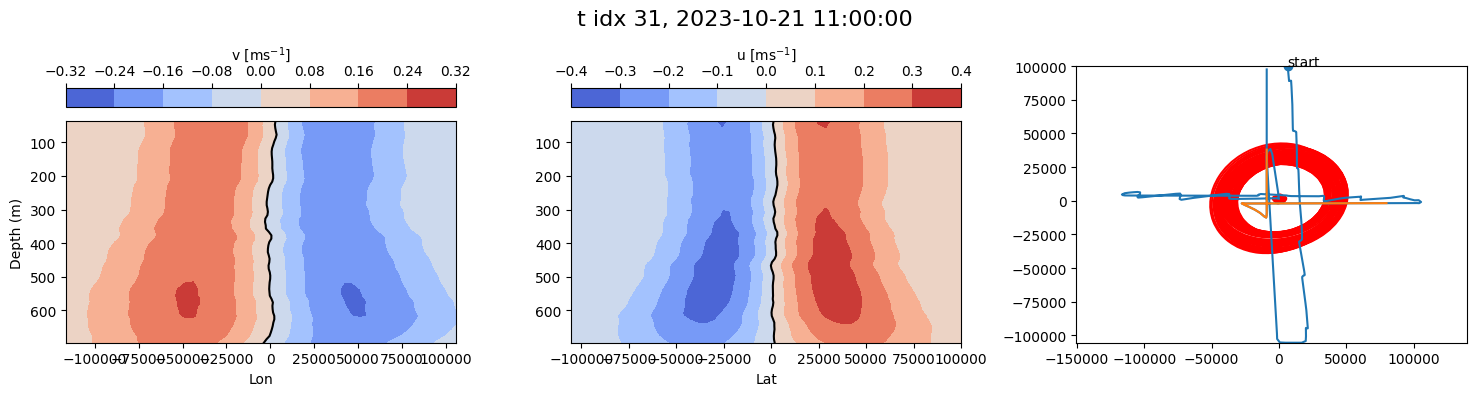

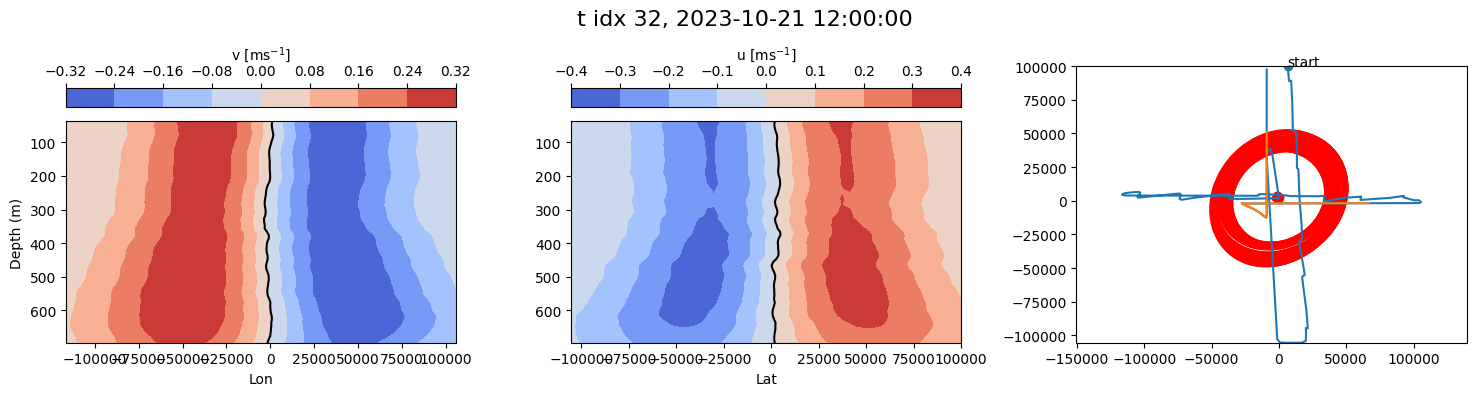

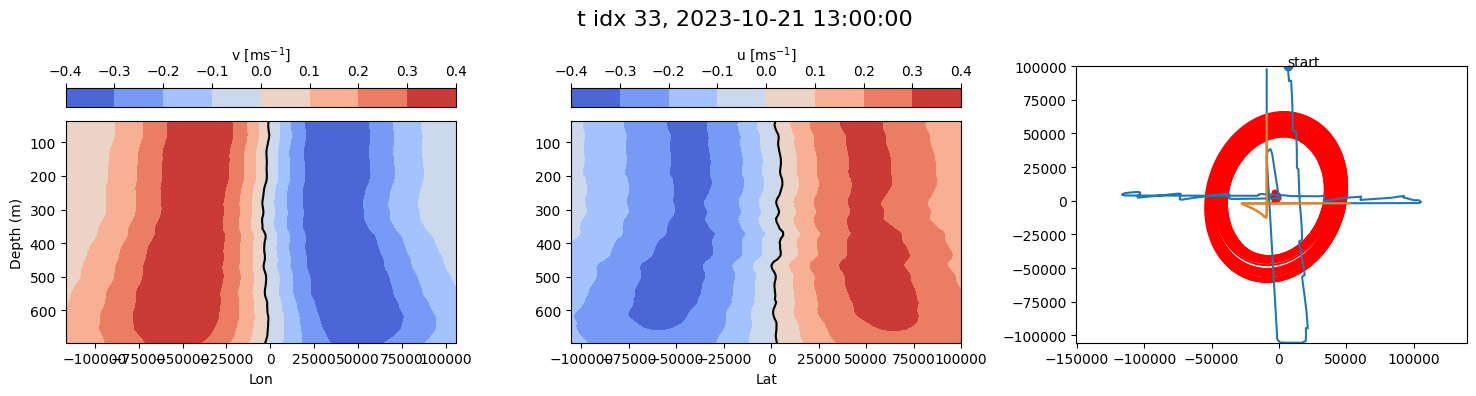

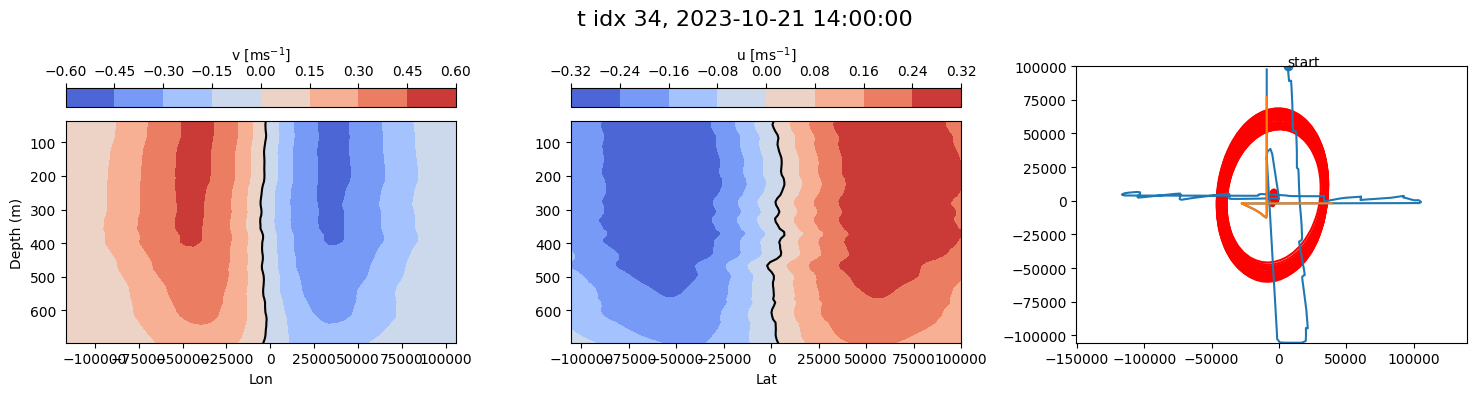

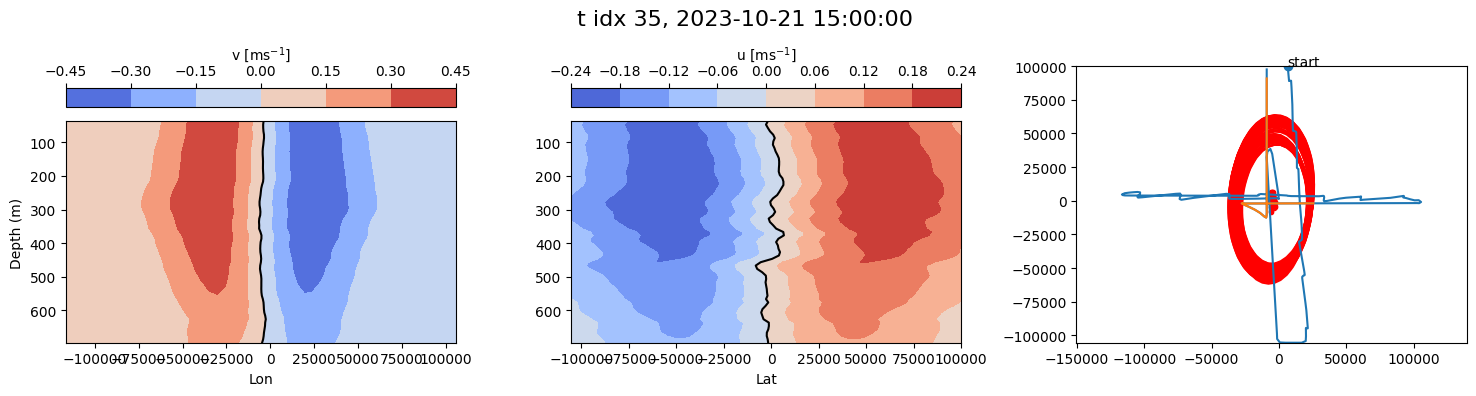

In [23]:
for t_idx in range(len(dic_tframe)):
    vel_plotter(t_idx)
    

In [24]:
t = list(dic_tframe.keys())[t_idx]
df = dic_tframe[t].copy()
df


xc           yc         w  \
0  -3913.673938 -1835.281834 -0.000031   
1  -4123.309763 -2765.561938 -0.000031   
2  -4098.483339 -1759.981469 -0.000031   
3  -3958.545865  -648.377582 -0.000031   
4  -3657.322147  1030.345918 -0.000031   
..          ...          ...       ...   
62 -3369.240624 -1558.190535 -0.000019   
63 -3667.967408 -2325.658316 -0.000019   
64 -3841.991220 -2367.485222 -0.000019   
65 -4148.414933 -1868.117950 -0.000019   
66 -4721.954724 -1632.469284 -0.000018   

                                                    Q            Rc  \
0   [[1.979577786311143, -0.0977763473827492], [-0...  39136.260056   
1   [[2.0036340370459733, -0.09628844393875027], [...  52741.938729   
2   [[1.9942741499506462, -0.08662940681146987], [...  45952.880112   
3   [[1.994880328327879, -0.07143488867704097], [-...  45775.388108   
4   [[1.9602960048157525, -0.07055691156933373], [...  44984.137436   
..                                                ...           ...   
62  [[1.8180291920352896, -0.09798968465463227], [...  50798.182661   
63  [[1.8425218497461242, -0.11092824445961291], [...  51306.762701   
64  [[1.8611276851110663, -0.11057656307852531], [...  51016.607722   
65  [[1.8408032737233357, -0.08571730271686726], [...  50239.372167   
66  [[1.7547882038430214, -0.09164266639343924], [...  50889.284279   

            psi0         A  Depth  
0    9587.906690 -0.000006     37  
1   17222.254065 -0.000006     47  
2   13216.777630 -0.000006     57  
3   13133.018581 -0.000006     67  
4   12597.451725 -0.000006     77  
..           ...       ...    ...  
62  10485.738968 -0.000004    657  
63  10529.179238 -0.000004    667  
64  10308.846927 -0.000004    677  
65  10047.675270 -0.000004    687  
66   9799.493444 -0.000004    697  

[67 rows x 8 columns]

#### IMOS Data

In [25]:
t_idx = 12

t_esp = list(dic_tframe.keys())[t_idx]
df_esp = dic_tframe[t_esp].copy()

# df['sRc'], _, _ = robust_smooth(np.arange(len(df)), df.Rc)
df_esp['sRc'] = smooth(df_esp.Rc, df_esp.Depth, window=300) 
df_esp['sA'], _, _ = robust_smooth(np.arange(len(df_esp)), df_esp.A)

df_esp['sq11'], _, _ = robust_smooth(np.arange(len(df_esp)), df_esp.Q.apply(lambda Q: Q[0,0]))
df_esp['sq12'], _, _ = robust_smooth(np.arange(len(df_esp)), df_esp.Q.apply(lambda Q: Q[1,0]))
df_esp['sq22'], _, _ = robust_smooth(np.arange(len(df_esp)), df_esp.Q.apply(lambda Q: Q[1,1]))

U = np.zeros((Lon.shape[0], Lon.shape[1], len(df_esp)))
V = np.zeros((Lon.shape[0], Lon.shape[1], len(df_esp)))

for k in range(len(df_esp)):
    data = df_esp.iloc[k]
    
    dx, dy = Lon - data.xc, Lat - data.yc
    rho2 = data.sq11*dx**2 + 2*data.sq12*dx*dy + data.sq22*dy**2
    U[:,:,k] = (- data.sA * np.exp( - rho2 / data.sRc**2 ) * ( 2*data.sq12*dx + 2*data.sq22*dy )).T
    V[:,:,k] = (  data.sA * np.exp( - rho2 / data.sRc**2 ) * ( 2*data.sq11*dx + 2*data.sq12*dy )).T

closest = min(tim_ssh, key=lambda t: abs(t - t_esp))
ut, vt = dic_ssh_data[closest]['u'], dic_ssh_data[closest]['v']


Max CS 0.4409689224394332
Max CS 0.7995236443425163


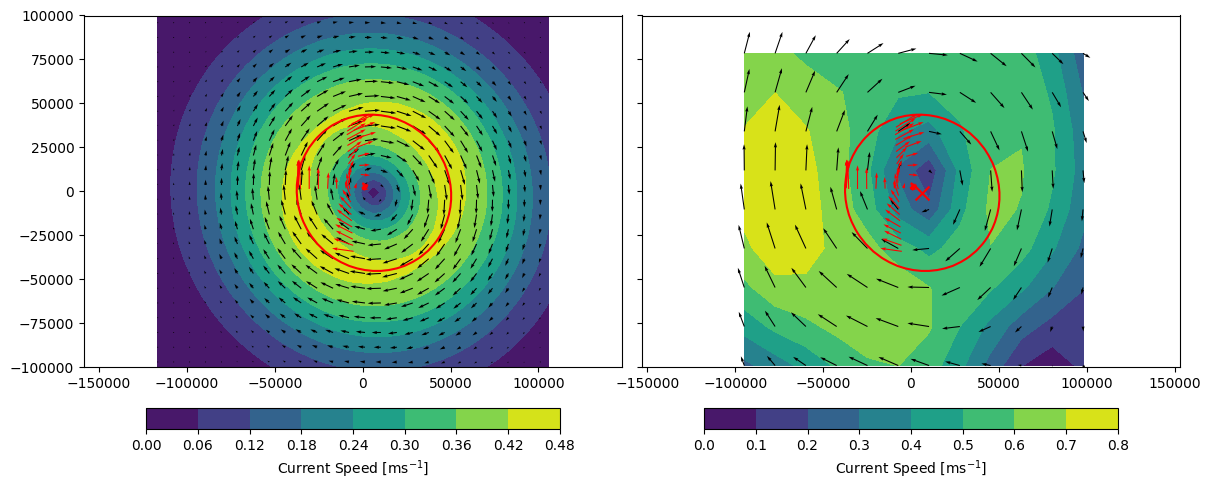

In [27]:
k = 0

data = df_esp.iloc[k]
dx, dy = Lon - data.xc, Lat - data.yc
rho2 = data.Q[0,0]*dx**2 + 2*data.Q[0,1]*dx*dy + data.Q[1,1]*dy**2
u = (- data.sA * np.exp( - rho2 / data.sRc**2 ) * ( 2*data.Q[0,1]*dx + 2*data.Q[1,1]*dy )).T
v = (  data.sA * np.exp( - rho2 / data.sRc**2 ) * ( 2*data.Q[0,0]*dx + 2*data.Q[0,1]*dy )).T

days = .3
df_sec = df_sadcp[(df_sadcp.Time >= t_esp - pd.Timedelta(days=days)) & (df_sadcp.Time <= t_esp + pd.Timedelta(days=days))]

fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# plot 1
cs1 = ax[0].contourf(Lon, Lat, np.hypot(u, v).T, cmap='viridis')
print(f'Max CS {np.hypot(u, v).max()}')
spac = 2
ax[0].quiver(Lon[::spac, ::spac], Lat[::spac, ::spac],
             u[::spac, ::spac].T, v[::spac, ::spac].T, scale=15, width=.002)
ax[0].contour(Lon, Lat, rho2, levels=[data.sRc**2/2], colors='r')
ax[0].quiver(df_sec.Lon, df_sec.Lat, df_sec[f'u_{data.Depth}'], df_sec[f'v_{data.Depth}'],
             scale=15, width=.002, color='r')
ax[0].axis('equal')
fig.colorbar(cs1, ax=ax[0], orientation='horizontal', fraction=0.05, pad=0.1,
             label=r'Current Speed [ms$^{-1}$]')

# plot 2
closest = min(tim_ssh, key=lambda t: abs(t - t_esp))
ut, vt = dic_ssh_data[closest]['u'], dic_ssh_data[closest]['v']

xmask = np.abs(x_ssh) <= 100000
ymask = np.abs(y_ssh) <= 100000
ix = np.where(xmask.any(axis=0))[0]
iy = np.where(ymask.any(axis=1))[0]
ut_sub = ut[iy.min():iy.max()+1, ix.min():ix.max()+1]
vt_sub = vt[iy.min():iy.max()+1, ix.min():ix.max()+1]
x_ssh_sub = x_ssh[iy.min():iy.max()+1, ix.min():ix.max()+1]
y_ssh_sub = y_ssh[iy.min():iy.max()+1, ix.min():ix.max()+1]

cs2 = ax[1].contourf(x_ssh_sub, y_ssh_sub, np.hypot(ut_sub, vt_sub), cmap='viridis')
print(f'Max CS {np.hypot(ut_sub, vt_sub).max()}')
ax[1].quiver(x_ssh_sub, y_ssh_sub, ut_sub, vt_sub, scale=15, width=.002)
ax[1].scatter(data.xc, data.yc, marker='x', color='r', s=100)
ax[1].contour(Lon, Lat, rho2, levels=[data.sRc**2/2], colors='r')
ax[1].quiver(df_sec.Lon, df_sec.Lat, df_sec[f'u_{data.Depth}'], df_sec[f'v_{data.Depth}'],
             scale=15, width=.002, color='r')
ax[1].axis('equal')
ax[1].set_xlim(-100000, 100000)
ax[1].set_ylim(-100000, 100000)
fig.colorbar(cs2, ax=ax[1], orientation='horizontal', fraction=0.05, pad=0.1,
             label=r'Current Speed [ms$^{-1}$]')

plt.tight_layout()
plt.show()


## MOCA Application


In [28]:
def sadcp_to_moca(x, y, u, v):

    num_points = len(x)

    df = pd.DataFrame({'x': x, 'y': y, 'u': u, 'v': v})
    df = df.sort_values(by='x').reset_index(drop=True)
    x, y, u, v = np.array(df['x']), np.array(df['y']), np.array(df['u']), np.array(df['v'])

    # Fit a best-fit line (y = m*x + c) using linear regression.
    A = np.vstack([x, np.ones(len(x))]).T
    m, _ = np.linalg.lstsq(A, y, rcond=None)[0]
    # Create a unit direction vector along the best-fit line.
    direction = np.array([1, m])
    direction = direction / np.linalg.norm(direction)
    # Project each (x, y) point onto the line using the first point as reference.
    p0 = np.array([x[0], y[0]])
    points = np.column_stack((x, y))
    projections = np.dot(points - p0, direction)
    # Sort projections and corresponding velocities.
    sort_idx = np.argsort(projections)
    proj_sorted = projections[sort_idx]
    u_sorted = u[sort_idx]
    v_sorted = v[sort_idx]
    # Interpolate the velocity components on evenly spaced positions.
    new_distances = np.linspace(proj_sorted.min(), proj_sorted.max(), num_points)
    new_u = np.interp(new_distances, proj_sorted, u_sorted)
    new_v = np.interp(new_distances, proj_sorted, v_sorted)
    # Calculate new (x, y) points along the line.
    new_points = p0 + np.outer(new_distances, direction)
    # Create and return the output dataframe.
    x, y = new_points[:, 0], new_points[:, 1]

    cos_theta = 1 / np.sqrt(1+m**2)
    sin_theta = m / np.sqrt(1+m**2)
    V_N = -new_u * sin_theta + new_v * cos_theta
    V_T = new_v * sin_theta + new_u * cos_theta
        
    df_projected = pd.DataFrame({
        'x': x,
        'y': y,
        'u': new_u,
        'v': new_v,
        'V_N': V_N,
        'V_T': V_T,
        # 'l': new_distances
    })

    df_projected = df_projected.sort_values(by='x').reset_index(drop=True)

    df_projected['l'] = np.hypot(df_projected['x']-df_projected['x'].iloc[0], df_projected['y']-df_projected['y'].iloc[0])

    return df_projected, m


def moca_to_cartesian(x_l_start, y_l_start, m, l0, r0):

    x0 = (l0-r0*m)/np.sqrt(1+m**2) + x_l_start
    y0 = (l0*m+r0)/np.sqrt(1+m**2) + y_l_start
    
    return x0, y0
    

(np.float64(-127677.08694791736),
 np.float64(116708.22479377297),
 np.float64(-115762.28835995645),
 np.float64(110372.67747337639))

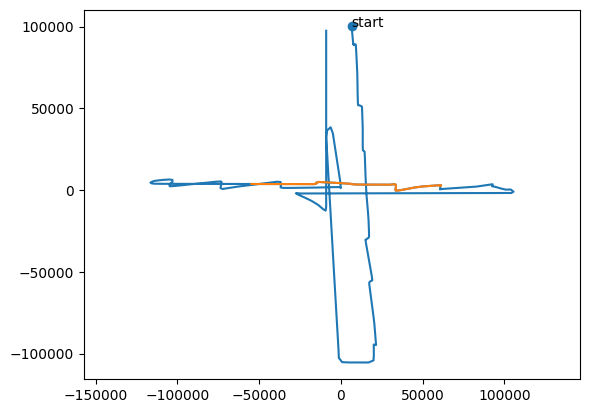

In [29]:
plt.plot(df_sadcp.Lon, df_sadcp.Lat)

# t_moc = pd.Timestamp('2023-10-18 2:00:00')
# days = .3

t_moc = pd.Timestamp('2023-10-20 12:00:00') # good
days = .3

# t_moc = pd.Timestamp('2023-10-20 11:00:00')
# days = .2

# t_moc = pd.Timestamp('2023-10-21 16:00:00')
# days = .1

df = df_sadcp[(df_sadcp.Time >= t_moc - pd.Timedelta(days=days)) & (df_sadcp.Time <= t_moc + pd.Timedelta(days=days))]
plt.plot(df.Lon, df.Lat)
plt.scatter(df_sadcp.Lon.iloc[0], df_sadcp.Lat.iloc[0])
plt.text(df_sadcp.Lon.iloc[0]+.1, df_sadcp.Lat.iloc[0], 'start')
plt.axis('equal')


xc           yc         w  \
0   2632.962223 -4345.268240 -0.000051   
1   2584.279890 -4096.427169 -0.000050   
2   2351.704444 -4095.741005 -0.000051   
3   2397.241244 -4163.713665 -0.000051   
4   1977.544200 -4453.167404 -0.000051   
..          ...          ...       ...   
62  1531.144494 -4383.780764 -0.000032   
63  2200.825829 -3997.385769 -0.000031   
64  3454.844375 -3452.136386 -0.000029   
65  3865.218407 -2675.001354 -0.000029   
66  3840.850265 -2460.201104 -0.000029   

                                                    Q            Rc  \
0   [[1.0000000000000004, -0.0], [-0.0, 1.00000000...  53073.852246   
1   [[0.9999999999999998, -0.0], [-0.0, 0.99999999...  50058.718581   
2   [[0.9999999999999993, -0.0], [-0.0, 0.99999999...  49163.150852   
3   [[1.0000000000000002, -0.0], [-0.0, 1.00000000...  62541.198763   
4   [[1.0000000000000004, -0.0], [-0.0, 1.00000000...  65509.236777   
..                                                ...           ...   
62  [[1.0000000000000007, -0.0], [-0.0, 1.00000000...  62043.445672   
63  [[0.9999999999999991, -0.0], [-0.0, 0.99999999...  62881.590469   
64  [[0.9999999999999997, -0.0], [-0.0, 0.99999999...  64081.260788   
65  [[1.0000000000000002, -0.0], [-0.0, 1.00000000...  59609.844018   
66  [[1.0000000000000004, -0.0], [-0.0, 1.00000000...  63005.019744   

            psi0         A  Depth           sRc        sA  
0   35616.277113 -0.000013     37  63586.133769 -0.000013  
1   31208.773162 -0.000012     47  62988.527109 -0.000013  
2   30516.003361 -0.000013     57  62383.191992 -0.000013  
3   49932.633071 -0.000013     67  62174.653510 -0.000013  
4   55243.219116 -0.000013     77  62066.594946 -0.000013  
..           ...       ...    ...           ...       ...  
62  31061.727425 -0.000008    657  51709.157996 -0.000008  
63  30600.831378 -0.000008    667  51949.649209 -0.000008  
64  29830.752391 -0.000007    677  52248.885877 -0.000008  
65  25924.124566 -0.000007    687  52598.056025 -0.000008  
66  28302.193691 -0.000007    697  53085.096191 -0.000008  

[67 rows x 10 columns]

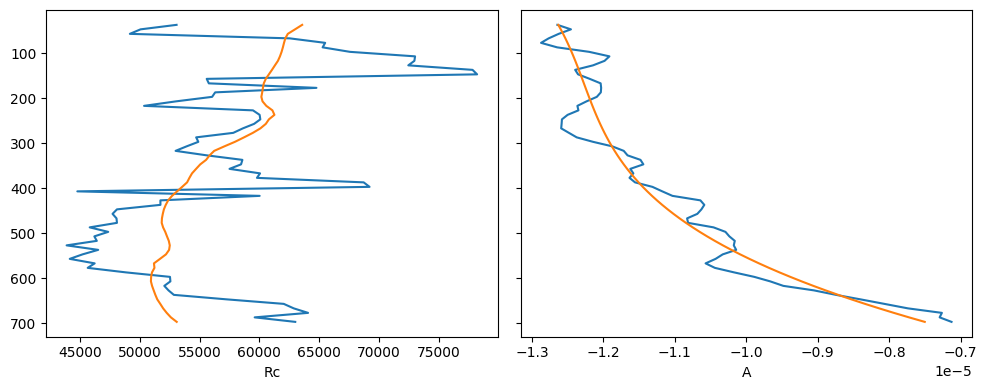

In [30]:
df_moca = pd.DataFrame(columns=['xc', 'yc', 'w', 'Q', 'Rc', 'psi0', 'A', 'Depth'])

u_cols = [col for col in df_sadcp.columns if 'u' in col]
v_cols = [col for col in df_sadcp.columns if 'v' in col]

df = df_sadcp[(df_sadcp.Time >= t_moc - pd.Timedelta(days=days)) & (df_sadcp.Time <= t_moc + pd.Timedelta(days=days))]
for (u_col, v_col) in zip(u_cols, v_cols):
    x1, y1, u1, v1 = df.Lon, df.Lat, df[u_col], df[v_col]
    mask = ~np.isnan(x1) & ~np.isnan(y1) & ~np.isnan(u1) & ~np.isnan(v1)
    x1, y1, u1, v1 = x1[mask], y1[mask], u1[mask], v1[mask]
    if len(x1) > 2:
        df_projected, m = sadcp_to_moca(x1, y1, u1, v1)
        l0, r0, w, Q, Rc, psi0, A = moca(df_projected.l, df_projected.V_T, df_projected.V_N, plot_flag=False, A_flag=True)
        xc, yc = moca_to_cartesian(df.iloc[0].Lon, df.iloc[0].Lat, m, l0, r0)
        depth = int(u_col[2:])
        if depth < 700:
            df_moca.loc[len(df_moca)] = {'xc': xc, 'yc': yc, 'w': w, 'Q': Q, 'Rc': Rc, 'psi0': psi0,
                                         'A': A, 'Depth': depth}
            
# df_moca['sRc'], _, _ = robust_smooth(np.arange(len(df_moca)), df_moca.Rc)
df_moca['sRc'] = smooth(df_moca.Rc, df_moca.Depth, window=500) 

df_moca['sA'], _, _ = robust_smooth(np.arange(len(df_moca)), df_moca.A)
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(10,4))
axs[0].plot(df_moca.Rc, df_moca.Depth)
axs[0].plot(df_moca.sRc, df_moca.Depth)
axs[0].set_xlabel('Rc')
axs[1].plot(df_moca.A, df_moca.Depth)
axs[1].plot(df_moca.sA, df_moca.Depth)
axs[1].set_xlabel('A')
axs[0].invert_yaxis()
plt.tight_layout()
df_moca
            

(np.float64(-116568.66368693142),
 np.float64(105599.80153278704),
 np.float64(-105483.42627662314),
 np.float64(100093.81539004308))

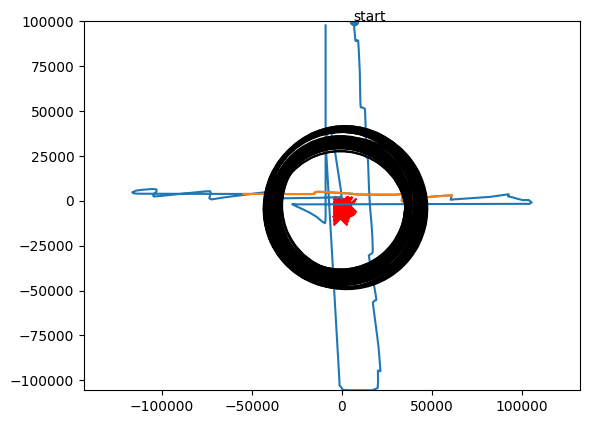

In [31]:
lon = np.linspace(df_sadcp.Lon.min(), df_sadcp.Lon.max())
lat = np.linspace(df_sadcp.Lat.min(), df_sadcp.Lat.max())
Lon, Lat = np.meshgrid(lon, lat)

plt.plot(df_sadcp.Lon, df_sadcp.Lat)
plt.plot(df.Lon, df.Lat)
plt.scatter(df_sadcp.Lon.iloc[0], df_sadcp.Lat.iloc[0])
plt.text(df_sadcp.Lon.iloc[0]+.1, df_sadcp.Lat.iloc[0], 'start')

for k in range(len(df_moca)):
    data = df_moca.iloc[k]
    plt.scatter(data.xc, data.yc, marker='x', color='r', s=100)
    
    dx_ell, dy_ell = Lon - data.xc, Lat - data.yc
    rho2_ell = data.Q[0,0]*dx_ell**2 + 2*data.Q[0,1]*dx_ell*dy_ell + data.Q[1,1]*dy_ell**2
    plt.contour(Lon, Lat, rho2_ell, levels=[data.sRc**2/2], colors='k')

plt.axis('equal')


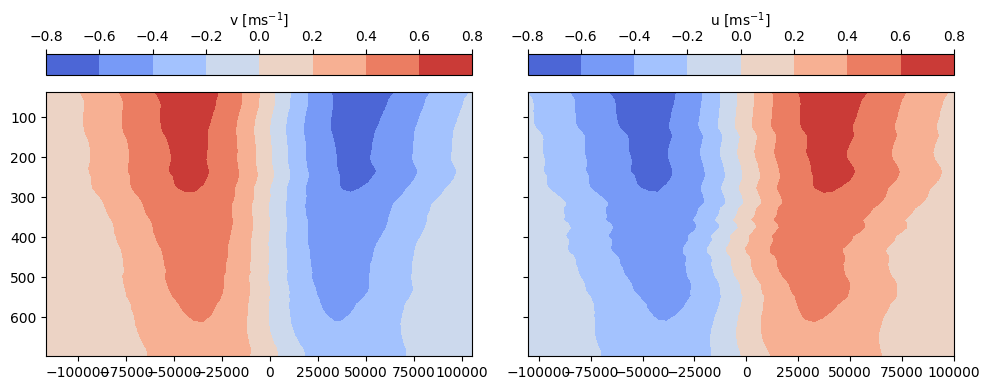

In [32]:
U = np.zeros((Lon.shape[0], Lon.shape[1], len(df_moca)))
V = np.zeros((Lon.shape[0], Lon.shape[1], len(df_moca)))
for k in range(len(df_moca)):
    data = df_moca.iloc[k]
    dx, dy = Lon - data.xc, Lat - data.yc
    rho2 = data.Q[0,0]*dx**2 + 2*data.Q[0,1]*dx*dy + data.Q[1,1]*dy**2
    U[:,:,k] = (- data.sA * np.exp( - rho2 / data.sRc**2 ) * ( 2*data.Q[0,1]*dx + 2*data.Q[1,1]*dy )).T
    V[:,:,k] = (  data.sA * np.exp( - rho2 / data.sRc**2 ) * ( 2*data.Q[0,0]*dx + 2*data.Q[0,1]*dy )).T

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(10, 4))

xc_surf, yc_surf = df_moca.iloc[0].xc, df_moca.iloc[0].yc
ic_surf = np.argmin(np.abs(lon - xc_surf))
jc_surf = np.argmin(np.abs(lat - yc_surf))

c1 = axs[0].contourf(lon, df_moca.Depth, V[:, jc_surf, :].T, cmap='coolwarm')
# axs[0].plot(df_moca.xc, df_moca.Depth)
c2 = axs[1].contourf(lat, df_moca.Depth, U[ic_surf, :, :].T , cmap='coolwarm')
# axs[1].plot(df_moca.yc, df_moca.Depth)
axs[0].invert_yaxis()

fig.colorbar(c1, ax=axs[0], orientation='horizontal', location='top', label=r'v [ms$^{-1}$]')
fig.colorbar(c2, ax=axs[1], orientation='horizontal', location='top', label=r'u [ms$^{-1}$]')

plt.tight_layout()
plt.show()


(np.float64(-116568.66368693142),
 np.float64(105599.80153278704),
 np.float64(-105483.42627662314),
 np.float64(100093.81539004308))

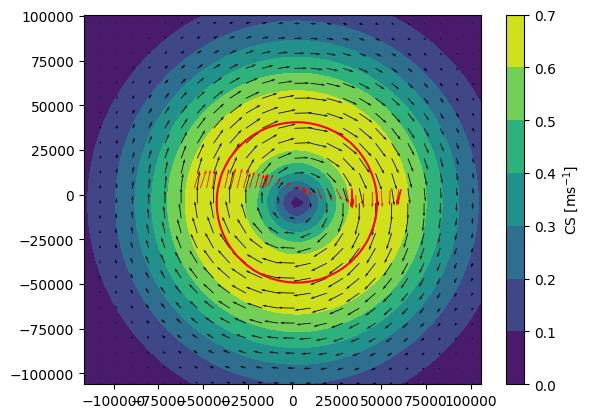

In [33]:
k = 0

data = df_moca.iloc[k]
dx, dy = Lon - data.xc, Lat - data.yc
rho2 = data.Q[0,0]*dx**2 + 2*data.Q[0,1]*dx*dy + data.Q[1,1]*dy**2
u = (- data.sA * np.exp( - rho2 / data.sRc**2 ) * ( 2*data.Q[0,1]*dx + 2*data.Q[1,1]*dy )).T
v = (  data.sA * np.exp( - rho2 / data.sRc**2 ) * ( 2*data.Q[0,0]*dx + 2*data.Q[0,1]*dy )).T

plt.contourf(Lon, Lat, np.hypot(u, v).T)
plt.colorbar(label=r'CS [ms$^{-1}$]')
spac = 2
plt.quiver(Lon[::spac, ::spac], Lat[::spac, ::spac],
           u[::spac, ::spac].T, v[::spac, ::spac].T, scale=15, width=.002)

plt.contour(Lon, Lat, rho2, levels=[data.sRc**2/2], colors='r')
plt.quiver(df.Lon, df.Lat, df[f'u_{data.Depth}'], df[f'v_{data.Depth}'], scale=15, width=.002, color='r')

plt.axis('equal')


#### IMOS Data

Max CS 0.6889498443928728
Max CS 0.7346271225373833


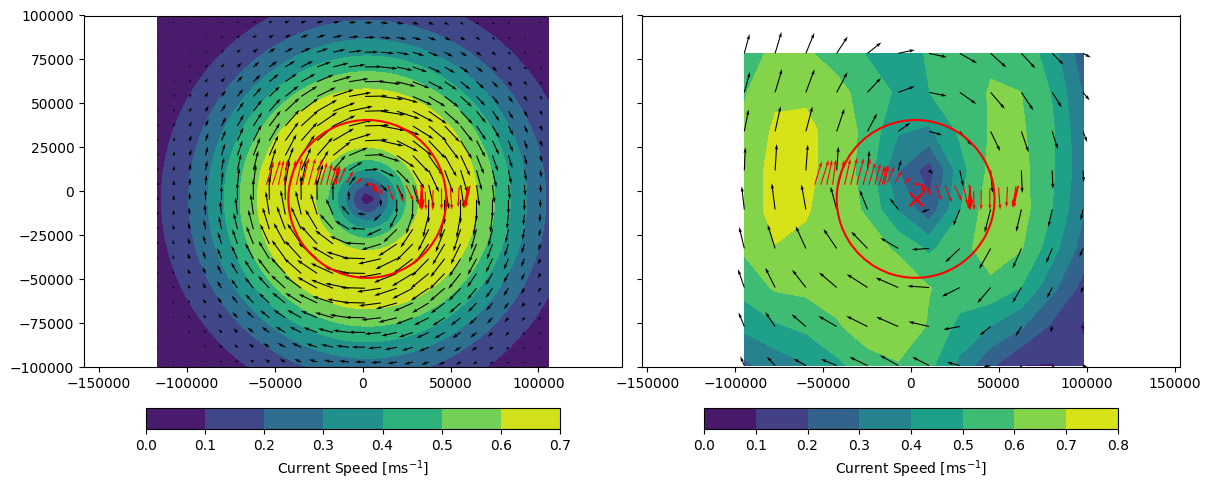

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# plot 1
cs1 = ax[0].contourf(Lon, Lat, np.hypot(u, v).T, cmap='viridis')
print(f'Max CS {np.hypot(u, v).max()}')
spac = 2
ax[0].quiver(Lon[::spac, ::spac], Lat[::spac, ::spac],
             u[::spac, ::spac].T, v[::spac, ::spac].T, scale=15, width=.002)
ax[0].contour(Lon, Lat, rho2, levels=[data.sRc**2/2], colors='r')
ax[0].quiver(df.Lon, df.Lat, df[f'u_{data.Depth}'], df[f'v_{data.Depth}'],
             scale=15, width=.002, color='r')
ax[0].axis('equal')
fig.colorbar(cs1, ax=ax[0], orientation='horizontal', fraction=0.05, pad=0.1,
             label=r'Current Speed [ms$^{-1}$]')

# plot 2
closest = min(tim_ssh, key=lambda t: abs(t - t_moc))
ut, vt = dic_ssh_data[closest]['u'], dic_ssh_data[closest]['v']

xmask = np.abs(x_ssh) <= 100000
ymask = np.abs(y_ssh) <= 100000
ix = np.where(xmask.any(axis=0))[0]
iy = np.where(ymask.any(axis=1))[0]
ut_sub = ut[iy.min():iy.max()+1, ix.min():ix.max()+1]
vt_sub = vt[iy.min():iy.max()+1, ix.min():ix.max()+1]
x_ssh_sub = x_ssh[iy.min():iy.max()+1, ix.min():ix.max()+1]
y_ssh_sub = y_ssh[iy.min():iy.max()+1, ix.min():ix.max()+1]

cs2 = ax[1].contourf(x_ssh_sub, y_ssh_sub, np.hypot(ut_sub, vt_sub), cmap='viridis')
print(f'Max CS {np.hypot(ut_sub, vt_sub).max()}')
ax[1].quiver(x_ssh_sub, y_ssh_sub, ut_sub, vt_sub, scale=15, width=.002)
ax[1].scatter(data.xc, data.yc, marker='x', color='r', s=100)
ax[1].contour(Lon, Lat, rho2, levels=[data.sRc**2/2], colors='r')
ax[1].quiver(df.Lon, df.Lat, df[f'u_{data.Depth}'], df[f'v_{data.Depth}'],
             scale=15, width=.002, color='r')
ax[1].axis('equal')
ax[1].set_xlim(-100000, 100000)
ax[1].set_ylim(-100000, 100000)
fig.colorbar(cs2, ax=ax[1], orientation='horizontal', fraction=0.05, pad=0.1,
             label=r'Current Speed [ms$^{-1}$]')

plt.tight_layout()
plt.show()
